# Experiments with real data (Heart Disease)

https://archive.ics.uci.edu/dataset/45/heart+disease

## Requirements

In [2]:
import os, sys, pickle
import polars as pl
import numpy as np
import matplotlib.pyplot as plt  
import seaborn as sns
from BigEDA.descriptive import outliers_table, summary
from BigEDA.plots import boxplot_matrix, histogram_matrix, barplot_matrix, ecdfplot_matrix
from datetime import datetime
from zoneinfo import ZoneInfo  
from tqdm import tqdm
import random
from sklearn.metrics import accuracy_score, balanced_accuracy_score
import pandas as pd
from PyDistances.mixed import FastGGowerDistMatrix
from sklearn.manifold import MDS
from FastKmedoids.plots import clustering_MDS_plot_multiple_methods
from FastKmedoids.models import FastKmedoidsGGower, FoldFastKmedoidsGGower
from sklearn_extra.cluster import KMedoids, CLARA
from sklearn.cluster import (KMeans, AgglomerativeClustering,
                             SpectralClustering, SpectralBiclustering, SpectralCoclustering, Birch, 
                             BisectingKMeans, MiniBatchKMeans)
from sklearn.mixture import GaussianMixture
from clustpy.partition import SubKmeans, LDAKmeans, DipInit
from clustpy.hierarchical import Diana

sns.set_style('whitegrid')

current_path = os.getcwd()
data_path = os.path.join(current_path, '..', '..', 'data')
data_filename = 'uci_heart_disease_processed.pkl'
data_file_path = os.path.join(data_path, data_filename)

src_path = os.path.join(current_path, '..', '..', 'src')
config_path = os.path.join(current_path, '..', '..', 'config')

sys.path.append(src_path)
sys.path.append(config_path)

from experiments_utils import (make_experiment_1, 
                               make_experiment_3, 
                               make_experiment_4,
                               get_pivoted_results, get_avg_results,
                               get_pivoted_results_two_iterables,
                               get_avg_results_two_iterables,
                               avg_results_to_dfs,
                               get_GGower_distances_names,
                               split_list_in_chunks)

from config_experiment_1_heart_disease import get_config as get_config_exp_1_heart_disease
from config_experiment_3_heart_disease import get_config as get_config_exp_3_heart_disease
from config_experiment_4_heart_disease import get_config as get_config_exp_4_heart_disease

## Data exploration


### Conceptual description

| Variable     | Descripción                                                                                           | Tipo                         | Valores                                                                                  |
|--------------|--------------------------------------------------------------------------------------------------------|------------------------------|--------------------------------------------------------------------------------------------------|
| age          | Edad del paciente en años al momento del estudio.                                                      | Numérica (entera)            | 29 – 77                                                                                  |
| sex          | Sexo del paciente.                                                                                     | Binaria                      | `male (1)`, `female (0)`                                                                 |
| cp           | Tipo de dolor torácico experimentado.                                                                 | Categórica nominal           | `typical angina (1)`, `atypical angina (2)`, `non-anginal pain (3)`, `asymptomatic (4)`    |
| trestbps     | Presión arterial en reposo (mm Hg) medida al ingreso hospitalario.                                     | Numérica (entera)            | 94 – 200                                                                                  |
| chol         | Colesterol sérico total (mg/dl).                                                                      | Numérica (entera)            | 126 – 564                                                                                 |
| fbs          | Azúcar en ayunas mayor a 120 mg/dl.                                                                  | Binaria                      | `true (1)`, `false (0)`                                                                   |
| restecg      | Resultados del electrocardiograma (ECG) en reposo.                                                    | Categórica nominal           | `normal (0)`, `ST-T wave abnormality (1)`, `left ventricular hypertrophy (2)`              |
| thalach      | Frecuencia cardíaca máxima alcanzada.                                                                 | Numérica (entera)            | 71 – 202                                                                                  |
| exang        | Angina inducida por ejercicio.                                                                        | Binaria                      | `yes (1)`, `no (0)`                                                                       |
| oldpeak      | Depresión del segmento ST inducida por ejercicio relativa al reposo.                                   | Numérica (continua)          | 0 – 6.2                                                                                    |
| slope        | Pendiente del segmento ST al ejercicio máximo.                                                        | Categórica ordinal           | `upsloping (1)`, `flat (2)`, `downsloping (3)`                                             |
| ca           | Número de vasos principales (0–3) coloreados por fluoroscopia.                                        | Numérica (entera)            | 0 – 3                                                                                      |
| thal         | Resultado del test de talio.                                                                          | Categórica nominal           | `normal (3)`, `fixed defect (6)`, `reversible defect (7)`                                   |
| num (target) | Diagnóstico de enfermedad cardíaca.                                                                  | Binaria (redefinida)         | `ausencia (0)`, `presencia (1)` (originalmente 0 = ausencia, 1–4 = presencia leve a grave) |


### Data reading

In [3]:
with open(data_file_path, "rb") as f:
    loaded_data = pickle.load(f)

X, y, p1, p2, p3, encoding, quant_predictors, binary_predictors, multiclass_predictors = loaded_data.values()

n_clusters = len(y.unique())

### Data view

In [4]:
X.head()

age,trestbps,chol,thalach,oldpeak,ca,sex,fbs,exang,cp,restecg,slope,thal
i64,i64,i64,i64,f64,f64,i64,i64,i64,i64,i64,i64,f64
63,145,233,150,2.3,0.0,1,1,0,1,2,3,6.0
67,160,286,108,1.5,3.0,1,0,1,4,2,2,3.0
67,120,229,129,2.6,2.0,1,0,1,4,2,2,7.0
37,130,250,187,3.5,0.0,1,0,0,3,0,3,3.0
41,130,204,172,1.4,0.0,0,0,0,2,2,1,3.0


In [5]:
X.shape

(297, 13)

In [6]:
y.head(5)

num
i64
0
1
1
0
0


In [7]:
y.shape

(297, 1)

In [8]:
n_clusters

2

In [9]:
print(p1, p2, p3)

6 3 4


In [10]:
encoding

{'num': {2: 1, 3: 1, 4: 1}}

In [11]:
quant_predictors

['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'ca']

In [12]:
binary_predictors

['sex', 'fbs', 'exang']

In [13]:
multiclass_predictors

['cp', 'restecg', 'slope', 'thal']

### Data description

In [14]:
quant_summary, cat_summary = summary(df=X, quant_col_names = quant_predictors, cat_col_names = binary_predictors + multiclass_predictors)

In [15]:
quant_summary

,n_unique,perc_nan,mean,std,min,Q10,Q25,median,Q75,Q90,max,kurtosis,skew,prop_outliers
age,41,0.0,54.542088,9.049736,29.0,42.0,48.0,56.0,61.0,66.0,77.0,2.466854,-0.218663,0.0
trestbps,50,0.0,131.693603,17.762806,94.0,110.0,120.0,130.0,140.0,152.0,200.0,3.781192,0.696529,0.030303
chol,152,0.0,247.350168,51.997583,126.0,192.0,211.0,243.0,276.0,309.0,564.0,7.349479,1.112441,0.016835
thalach,91,0.0,149.599327,22.941562,71.0,116.0,133.0,153.0,166.0,177.0,202.0,2.928885,-0.533826,0.003367
oldpeak,40,0.0,1.055556,1.166123,0.0,0.0,0.0,0.8,1.6,2.8,6.2,4.46552,1.240824,0.016835
ca,4,0.0,0.676768,0.938965,0.0,0.0,0.0,0.0,1.0,2.0,3.0,3.211157,1.173582,0.06734


In [16]:
cat_summary

,n_unique,perc_nan,mode
sex,2,0.0,1
fbs,2,0.0,0
exang,2,0.0,0
cp,4,0.0,4
restecg,3,0.0,0
slope,3,0.0,1
thal,3,0.0,3.0


In [17]:
y.describe()

statistic,num
str,f64
"""count""",297.0
"""null_count""",0.0
"""mean""",0.461279
"""std""",0.49934
"""min""",0.0
"""25%""",0.0
"""50%""",0.0
"""75%""",1.0
"""max""",1.0


In [18]:
# Proportion of individuals per cluster/group
unique_values, counts = np.unique(y, return_counts=True)
prop_clusters = np.round(counts/len(y), 2)
prop_clusters = {k: v for k, v in zip(unique_values, prop_clusters)}
print(f'prop_clusters: {prop_clusters}')

prop_clusters: {0: 0.54, 1: 0.46}


In [20]:
outliers_df = outliers_table(X, auto=False, col_names=quant_predictors, h=1.5)
outliers_df

quant_variables,lower_bound,upper_bound,n_outliers,n_not_outliers,prop_outliers,prop_not_outliers
str,f64,f64,i64,i64,f64,f64
"""age""",28.5,80.5,0,297,0.0,1.0
"""trestbps""",90.0,170.0,9,288,0.030303,0.969697
"""chol""",113.5,373.5,5,292,0.016835,0.983165
"""thalach""",83.5,215.5,1,296,0.003367,0.996633
"""oldpeak""",-2.4,4.0,5,292,0.016835,0.983165
"""ca""",-1.5,2.5,20,277,0.06734,0.93266


In [21]:
outliers_df['prop_outliers'].mean()

0.02244668911335578

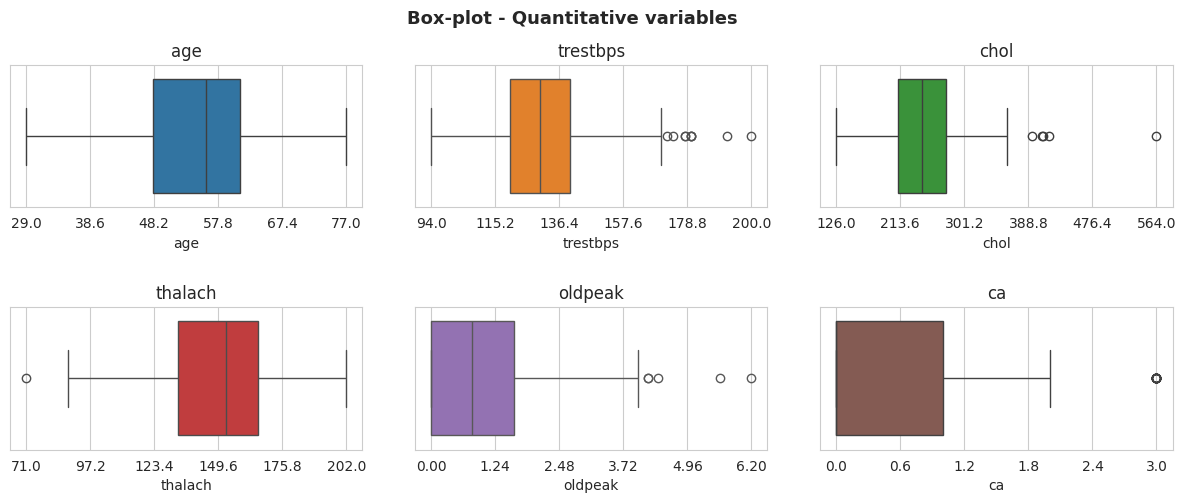

In [22]:
# Boxplot after outliers contamination
boxplot_matrix(X, 
               n_cols=3, 
               title='Box-plot - Quantitative variables', 
               figsize=(15,5), 
               quant_col_names=quant_predictors, 
               n_xticks=6, 
               title_fontsize=13, 
               save=False, 
               file_name='', 
               x_rotation=0, 
               title_height=0.99,
               style='whitegrid', 
               hspace=0.7, 
               wspace=0.15, 
               title_weight='bold',
               subtitles_fontsize=12, 
               xlabel_size=10)

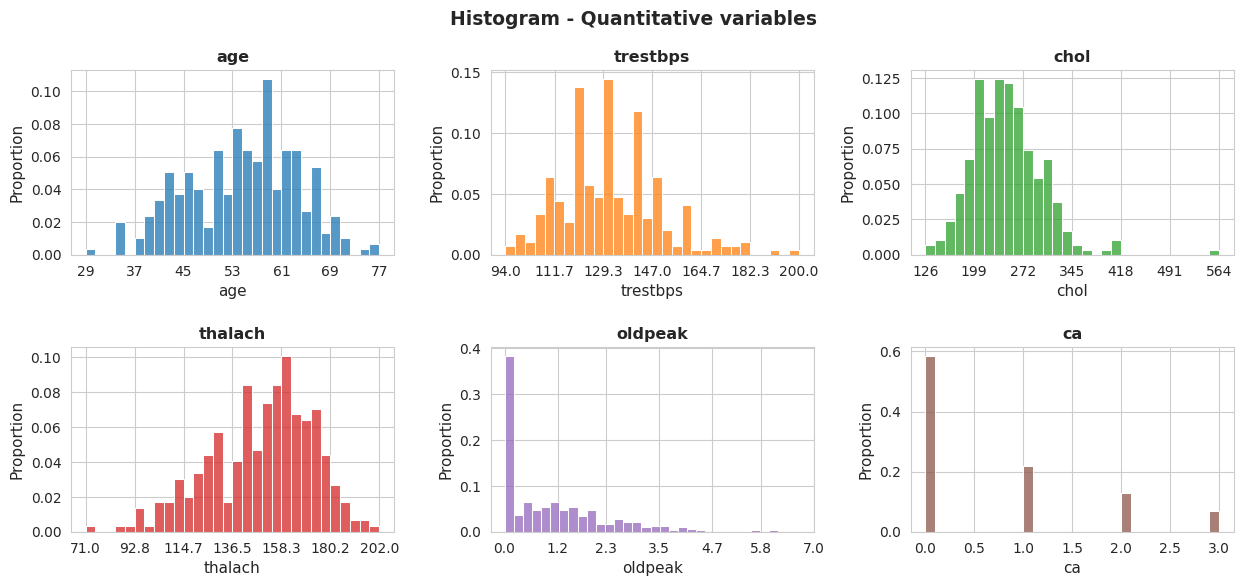

In [23]:
# Histogram
histogram_matrix(df=X, bins=30, n_cols=3, title='Histogram - Quantitative variables', 
                 figsize=(15,6), quant_col_names=quant_predictors, 
                 n_xticks=7, title_fontsize=13.5, 
                 subtitles_fontsize=11.5, save=False, file_name='', x_rotation=0, title_height=0.98,
                 style='whitegrid', hspace=0.5, wspace=0.3, n_round_xticks=1)

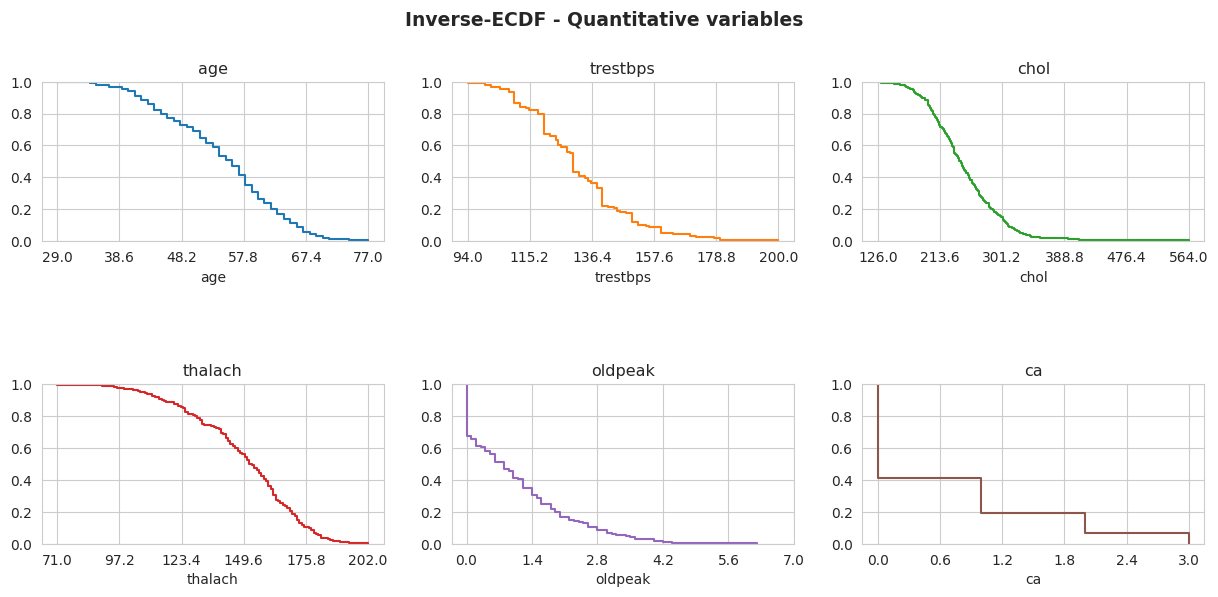

In [24]:
ecdfplot_matrix(df=X, 
                n_cols=3, 
                title='Inverse-ECDF - Quantitative variables', 
                complementary=True, 
                figsize=(15,6), 
                auto_col=False, 
                quant_col_names = quant_predictors, 
                title_weight='bold',
                n_xticks=6, 
                title_fontsize=13.5, 
                subtitles_fontsize=11.5, 
                save=False, 
                file_name=None, 
                random=False, 
                n=None, 
                fraction=None, 
                seed=123, 
                x_rotation=0, 
                title_height=1,
                style='whitegrid', 
                hspace=0.9, 
                wspace=0.2,
                n_round_xticks=2, 
                xlabel_size=10) 

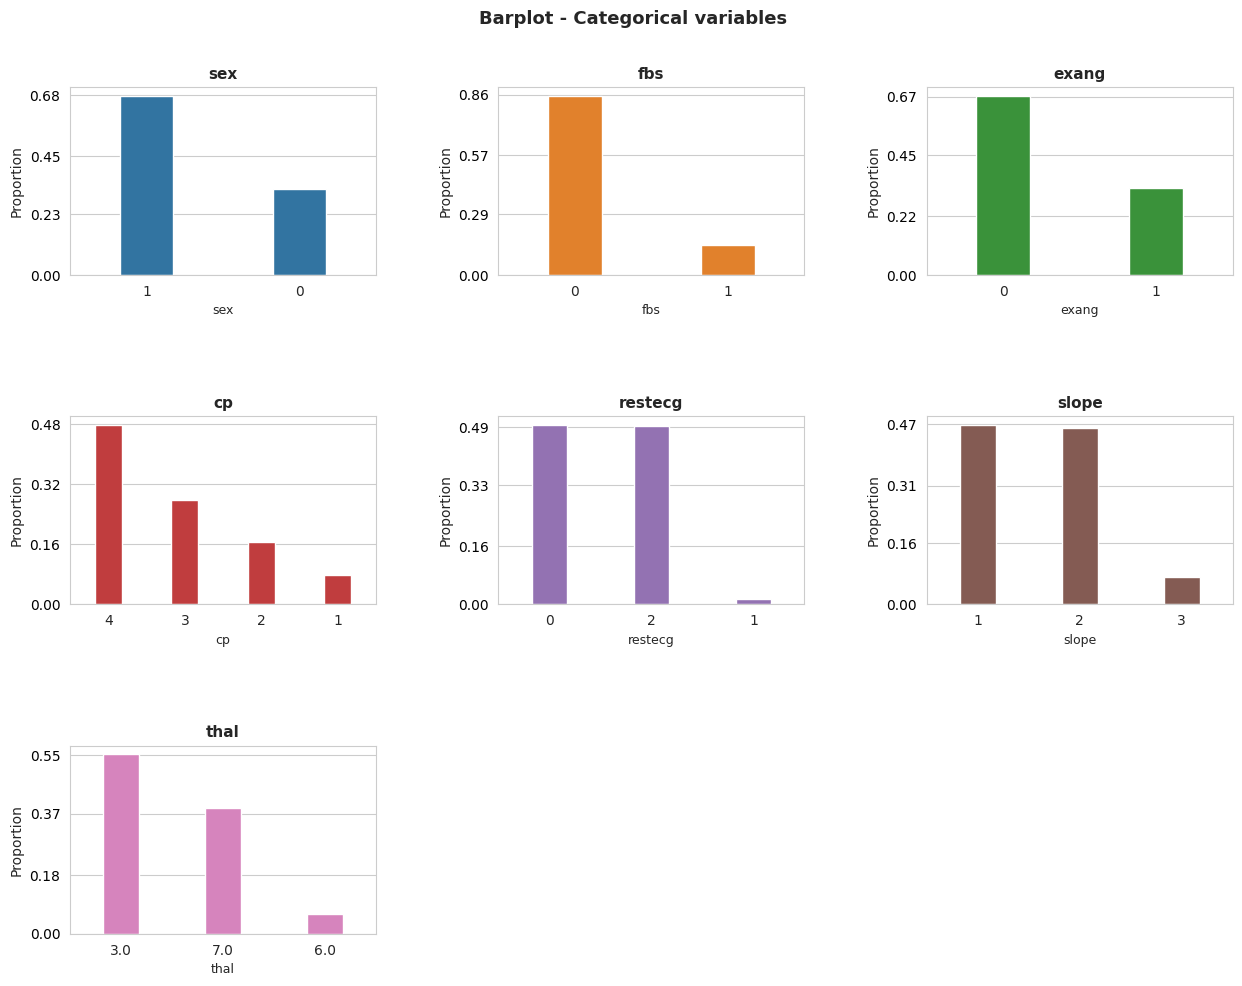

In [25]:
# Barplot
barplot_matrix(df=X, 
               n_cols=3, 
               title='Barplot - Categorical variables', 
               figsize=(15,11), 
               cat_col_names = binary_predictors + multiclass_predictors, 
               title_fontsize=13, 
               subtitles_fontsize=11, 
               save=False, 
               file_name='', 
               x_rotation=0, 
               title_height=0.95,
               style='whitegrid', 
               hspace=0.75, 
               wspace=0.4, 
               title_weight='bold', 
               bar_width=0.35,
               ylabel_size=10, 
               xlabel_size=9, 
               xticks_size=10)

In [26]:
# Correlation Matrix
X[quant_predictors].to_pandas().corr()

,age,trestbps,chol,thalach,oldpeak,ca
age,1.000000,0.290476,0.202644,-0.394563,0.197123,0.362210
trestbps,0.290476,1.000000,0.131536,-0.049108,0.191243,0.097954
chol,0.202644,0.131536,1.000000,-0.000075,0.038596,0.115945
thalach,-0.394563,-0.049108,-0.000075,1.000000,-0.347640,-0.268727
oldpeak,0.197123,0.191243,0.038596,-0.347640,1.000000,0.294452
ca,0.362210,0.097954,0.115945,-0.268727,0.294452,1.000000


In [27]:
# Correlation Analysis
corr_matrix = X[quant_predictors].corr().to_numpy()
n_corr = len(corr_matrix[np.triu_indices_from(corr_matrix, k=1)])
n_corr_below_30 = np.sum(np.abs(corr_matrix[np.triu_indices_from(corr_matrix, k=1)]) < 0.30)
n_corr_above_60 = np.sum(np.abs(corr_matrix[np.triu_indices_from(corr_matrix, k=1)]) > 0.60)
n_corr_between = np.sum((np.abs(corr_matrix[np.triu_indices_from(corr_matrix, k=1)]) >= 0.30) & (np.abs(corr_matrix[np.triu_indices_from(corr_matrix, k=1)]) <= 0.60))
                        
print('Proportion of pair-wise correlation > 0.60 (in abs. value): ', np.round(n_corr_above_60 / n_corr, 2))
print('Proportion of pair-wise correlations in [0.30, 0.60]: ', np.round(n_corr_between / n_corr, 2))
print('Proportion of pair-wise correlation < 0.30 (in abs. value): ', np.round(n_corr_below_30 / n_corr, 2))

Proportion of pair-wise correlation > 0.60 (in abs. value):  0.0
Proportion of pair-wise correlations in [0.30, 0.60]:  0.2
Proportion of pair-wise correlation < 0.30 (in abs. value):  0.8


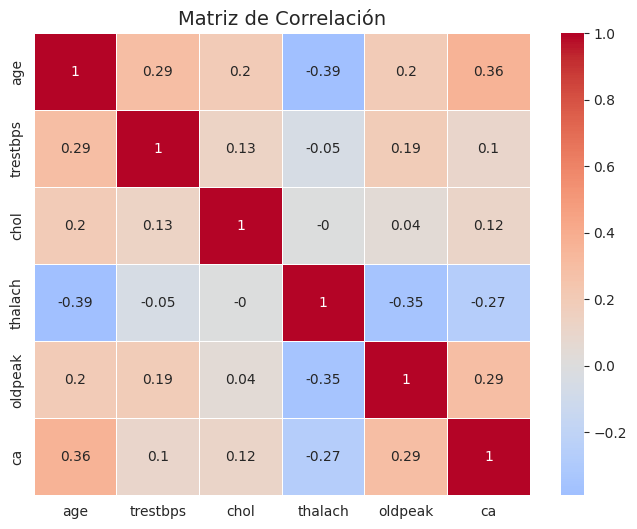

In [28]:
# Suponiendo que ya tienes tu matriz de correlaciones
corr = X[quant_predictors].to_pandas().corr().round(2)

plt.figure(figsize=(8,6))
sns.heatmap(corr, 
            annot=True,        # Muestra los valores dentro de cada celda
            cmap="coolwarm",   # Paleta de colores (azul-rojo)
            center=0,          # Centra el mapa en 0
            linewidths=0.5)    # Líneas entre celdas
plt.title("Matriz de Correlación", fontsize=14)
plt.show()



## Experiment 1


In [29]:
run_experiment_1 = True

In [32]:
if run_experiment_1: 
        
    n_realizations = 100
    experiment_random_state = 123 
    random.seed(experiment_random_state)
    random_state_list = random.sample(range(n_realizations*1000), n_realizations)

    chunk_size = 5
    random_state_list_chunks = split_list_in_chunks(random_state_list, chunk_size=chunk_size)

    results_folder_path = os.path.join(current_path, '..', '..', 'results', 'results_experiment_1', 'heart_disease')
    os.makedirs(results_folder_path, exist_ok=True)
    file_id = datetime.now(ZoneInfo("Europe/Madrid")).strftime('%Y%m%d_%H%M%S')
    file_id = '20250930_130045'

    config_exp_1 = get_config_exp_1_heart_disease()
   
    config_exp_1.update({
    'n_clusters': n_clusters,
    'p1': p1,
    'p2': p2,
    'p3': p3
    })

    if not isinstance(y, np.ndarray):
        y = y.to_numpy().flatten() # needed by adjusted_accuracy, which is used by make_experiment_1

In [33]:
if run_experiment_1: 

    for chunk_id, random_state_chunk in enumerate(tqdm(random_state_list_chunks, desc='chunks', unit='chunks', position=0)):
        print('random_state_chunk:', random_state_chunk)

        results = {}

        for random_state in random_state_chunk:
            print('random_state:', random_state)
                
            results[random_state] = make_experiment_1(**config_exp_1,
                                                    X=X, 
                                                    y=y,
                                                    random_state=random_state,
                                                    metric=accuracy_score
                                                )
            
        # Save results
        results_filename = f'results_exp_1_heart_disease_chunk_{chunk_id}_{file_id}.pkl'
        results_save_path = os.path.join(results_folder_path, results_filename)
        with open(results_save_path, 'wb') as f:
            pickle.dump(results, f)

# Time 100 realizations: 14 mins

chunks:   0%|          | 0/20 [00:00<?, ?chunks/s]

random_state_chunk: [6863, 35084, 11427, 53377, 34937]
random_state: 6863
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
frac_sample_size: 0.4
len y_pred: 2
frac_sample_size: 0.5
len y_pred: 2
frac_sample_size: 0.6
len y_pred: 2
frac_sample_size: 0.7
len y_pred: 2
frac_sample_size: 0.8
len y_pred: 2
frac_sample_size: 0.9
len y_pred: 2
random_state: 35084
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
frac_sample_size: 0.4
len y_pred: 2
frac_sample_size: 0.5
len y_pred: 2
frac_sample_size: 0.6
len y_pred: 2
frac_sample_size: 0.7
len y_pred: 2
frac_sample_size: 0.8
len y_pred: 2
frac_sample_size: 0.9
len y_pred: 2
random_state: 11427
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
frac_sample_size: 0.4
len y_pred: 2
frac_sample_size: 0.5
len y_pred: 2
frac_sample_size: 0.6
len y_pred: 2
frac_sample_size: 0.7


chunks:   5%|▌         | 1/20 [00:40<12:56, 40.86s/chunks]

len y_pred: 2
random_state_chunk: [14116, 5000, 49692, 70281, 73704]
random_state: 14116
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
frac_sample_size: 0.4
len y_pred: 2
frac_sample_size: 0.5
len y_pred: 2
frac_sample_size: 0.6
len y_pred: 2
frac_sample_size: 0.7
len y_pred: 2
frac_sample_size: 0.8
len y_pred: 2
frac_sample_size: 0.9
len y_pred: 2
random_state: 5000
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
frac_sample_size: 0.4
len y_pred: 2
frac_sample_size: 0.5
len y_pred: 2
frac_sample_size: 0.6
len y_pred: 2
frac_sample_size: 0.7
len y_pred: 2
frac_sample_size: 0.8
len y_pred: 2
frac_sample_size: 0.9
len y_pred: 2
random_state: 49692
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
frac_sample_size: 0.4
len y_pred: 2
frac_sample_size: 0.5
len y_pred: 2
frac_sample_size: 0.6
len y_pred: 2
frac_sam

chunks:  10%|█         | 2/20 [01:20<12:03, 40.19s/chunks]

len y_pred: 2
random_state_chunk: [43541, 44669, 6802, 20927, 17702]
random_state: 43541
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
frac_sample_size: 0.4
len y_pred: 2
frac_sample_size: 0.5
len y_pred: 2
frac_sample_size: 0.6
len y_pred: 2
frac_sample_size: 0.7
len y_pred: 2
frac_sample_size: 0.8
len y_pred: 2
frac_sample_size: 0.9
len y_pred: 2
random_state: 44669
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
frac_sample_size: 0.4
len y_pred: 2
frac_sample_size: 0.5
len y_pred: 2
frac_sample_size: 0.6
len y_pred: 2
frac_sample_size: 0.7
len y_pred: 2
frac_sample_size: 0.8
len y_pred: 2
frac_sample_size: 0.9
len y_pred: 2
random_state: 6802
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
frac_sample_size: 0.4
len y_pred: 2
frac_sample_size: 0.5
len y_pred: 2
frac_sample_size: 0.6
len y_pred: 2
frac_sam

chunks:  15%|█▌        | 3/20 [01:55<10:42, 37.80s/chunks]

len y_pred: 2
random_state_chunk: [44199, 73526, 43751, 91971, 32134]
random_state: 44199
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
frac_sample_size: 0.4
len y_pred: 2
frac_sample_size: 0.5
len y_pred: 2
frac_sample_size: 0.6
len y_pred: 2
frac_sample_size: 0.7
len y_pred: 2
frac_sample_size: 0.8
len y_pred: 2
frac_sample_size: 0.9
len y_pred: 2
random_state: 73526
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
frac_sample_size: 0.4
len y_pred: 2
frac_sample_size: 0.5
len y_pred: 2
frac_sample_size: 0.6
len y_pred: 2
frac_sample_size: 0.7
len y_pred: 2
frac_sample_size: 0.8
len y_pred: 2
frac_sample_size: 0.9
len y_pred: 2
random_state: 43751
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
frac_sample_size: 0.4
len y_pred: 2
frac_sample_size: 0.5
len y_pred: 2
frac_sample_size: 0.6
len y_pred: 2
frac_s

chunks:  20%|██        | 4/20 [02:43<11:09, 41.87s/chunks]

len y_pred: 2
random_state_chunk: [21466, 218, 57183, 11483, 78328]
random_state: 21466
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
frac_sample_size: 0.4
len y_pred: 2
frac_sample_size: 0.5
len y_pred: 2
frac_sample_size: 0.6
len y_pred: 2
frac_sample_size: 0.7
len y_pred: 2
frac_sample_size: 0.8
len y_pred: 2
frac_sample_size: 0.9
len y_pred: 2
random_state: 218
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
frac_sample_size: 0.4
len y_pred: 2
frac_sample_size: 0.5
len y_pred: 2
frac_sample_size: 0.6
len y_pred: 2
frac_sample_size: 0.7
len y_pred: 2
frac_sample_size: 0.8
len y_pred: 2
frac_sample_size: 0.9
len y_pred: 2
random_state: 57183
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
frac_sample_size: 0.4
len y_pred: 2
frac_sample_size: 0.5
len y_pred: 2
frac_sample_size: 0.6
len y_pred: 2
frac_sampl

chunks:  25%|██▌       | 5/20 [03:22<10:12, 40.83s/chunks]

len y_pred: 2
random_state_chunk: [49492, 9158, 864, 41347, 95949]
random_state: 49492
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
frac_sample_size: 0.4
len y_pred: 2
frac_sample_size: 0.5
len y_pred: 2
frac_sample_size: 0.6
len y_pred: 2
frac_sample_size: 0.7
len y_pred: 2
frac_sample_size: 0.8
len y_pred: 2
frac_sample_size: 0.9
len y_pred: 2
random_state: 9158
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
frac_sample_size: 0.4
len y_pred: 2
frac_sample_size: 0.5
len y_pred: 2
frac_sample_size: 0.6
len y_pred: 2
frac_sample_size: 0.7
len y_pred: 2
frac_sample_size: 0.8
len y_pred: 2
frac_sample_size: 0.9
len y_pred: 2
random_state: 864
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
frac_sample_size: 0.4
len y_pred: 2
frac_sample_size: 0.5
len y_pred: 2
frac_sample_size: 0.6
len y_pred: 2
frac_sample_

chunks:  30%|███       | 6/20 [04:05<09:39, 41.40s/chunks]

len y_pred: 2
random_state_chunk: [58762, 13374, 5752, 12158, 87443]
random_state: 58762
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
frac_sample_size: 0.4
len y_pred: 2
frac_sample_size: 0.5
len y_pred: 2
frac_sample_size: 0.6
len y_pred: 2
frac_sample_size: 0.7
len y_pred: 2
frac_sample_size: 0.8
len y_pred: 2
frac_sample_size: 0.9
len y_pred: 2
random_state: 13374
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
frac_sample_size: 0.4
len y_pred: 2
frac_sample_size: 0.5
len y_pred: 2
frac_sample_size: 0.6
len y_pred: 2
frac_sample_size: 0.7
len y_pred: 2
frac_sample_size: 0.8
len y_pred: 2
frac_sample_size: 0.9
len y_pred: 2
random_state: 5752
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
frac_sample_size: 0.4
len y_pred: 2
frac_sample_size: 0.5
len y_pred: 2
frac_sample_size: 0.6
len y_pred: 2
frac_sam

chunks:  35%|███▌      | 7/20 [04:41<08:36, 39.77s/chunks]

len y_pred: 2
random_state_chunk: [18635, 16547, 2783, 38247, 56444]
random_state: 18635
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
frac_sample_size: 0.4
len y_pred: 2
frac_sample_size: 0.5
len y_pred: 2
frac_sample_size: 0.6
len y_pred: 2
frac_sample_size: 0.7
len y_pred: 2
frac_sample_size: 0.8
len y_pred: 2
frac_sample_size: 0.9
len y_pred: 2
random_state: 16547
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
frac_sample_size: 0.4
len y_pred: 2
frac_sample_size: 0.5
len y_pred: 2
frac_sample_size: 0.6
len y_pred: 2
frac_sample_size: 0.7
len y_pred: 2
frac_sample_size: 0.8
len y_pred: 2
frac_sample_size: 0.9
len y_pred: 2
random_state: 2783
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
frac_sample_size: 0.4
len y_pred: 2
frac_sample_size: 0.5
len y_pred: 2
frac_sample_size: 0.6
len y_pred: 2
frac_sam

chunks:  40%|████      | 8/20 [05:23<08:05, 40.47s/chunks]

len y_pred: 2
random_state_chunk: [75157, 62511, 34776, 61511, 4816]
random_state: 75157
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
frac_sample_size: 0.4
len y_pred: 2
frac_sample_size: 0.5
len y_pred: 2
frac_sample_size: 0.6
len y_pred: 2
frac_sample_size: 0.7
len y_pred: 2
frac_sample_size: 0.8
len y_pred: 2
frac_sample_size: 0.9
len y_pred: 2
random_state: 62511
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
frac_sample_size: 0.4
len y_pred: 2
frac_sample_size: 0.5
len y_pred: 2
frac_sample_size: 0.6
len y_pred: 2
frac_sample_size: 0.7
len y_pred: 2
frac_sample_size: 0.8
len y_pred: 2
frac_sample_size: 0.9
len y_pred: 2
random_state: 34776
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
frac_sample_size: 0.4
len y_pred: 2
frac_sample_size: 0.5
len y_pred: 2
frac_sample_size: 0.6
len y_pred: 2
frac_sa

chunks:  45%|████▌     | 9/20 [06:02<07:18, 39.89s/chunks]

len y_pred: 2
random_state_chunk: [39989, 45018, 68376, 63302, 27113]
random_state: 39989
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
frac_sample_size: 0.4
len y_pred: 2
frac_sample_size: 0.5
len y_pred: 2
frac_sample_size: 0.6
len y_pred: 2
frac_sample_size: 0.7
len y_pred: 2
frac_sample_size: 0.8
len y_pred: 2
frac_sample_size: 0.9
len y_pred: 2
random_state: 45018
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
frac_sample_size: 0.4
len y_pred: 2
frac_sample_size: 0.5
len y_pred: 2
frac_sample_size: 0.6
len y_pred: 2
frac_sample_size: 0.7
len y_pred: 2
frac_sample_size: 0.8
len y_pred: 2
frac_sample_size: 0.9
len y_pred: 2
random_state: 68376
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
frac_sample_size: 0.4
len y_pred: 2
frac_sample_size: 0.5
len y_pred: 2
frac_sample_size: 0.6
len y_pred: 2
frac_s

chunks:  50%|█████     | 10/20 [06:53<07:13, 43.33s/chunks]

len y_pred: 2
random_state_chunk: [79810, 83723, 69084, 74031, 41322]
random_state: 79810
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
frac_sample_size: 0.4
len y_pred: 2
frac_sample_size: 0.5
len y_pred: 2
frac_sample_size: 0.6
len y_pred: 2
frac_sample_size: 0.7
len y_pred: 2
frac_sample_size: 0.8
len y_pred: 2
frac_sample_size: 0.9
len y_pred: 2
random_state: 83723
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
frac_sample_size: 0.4
len y_pred: 2
frac_sample_size: 0.5
len y_pred: 2
frac_sample_size: 0.6
len y_pred: 2
frac_sample_size: 0.7
len y_pred: 2
frac_sample_size: 0.8
len y_pred: 2
frac_sample_size: 0.9
len y_pred: 2
random_state: 69084
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
frac_sample_size: 0.4
len y_pred: 2
frac_sample_size: 0.5
len y_pred: 2
frac_sample_size: 0.6
len y_pred: 2
frac_s

chunks:  55%|█████▌    | 11/20 [07:42<06:46, 45.17s/chunks]

len y_pred: 2
random_state_chunk: [1644, 52197, 84692, 67207, 56935]
random_state: 1644
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
frac_sample_size: 0.4
len y_pred: 2
frac_sample_size: 0.5
len y_pred: 2
frac_sample_size: 0.6
len y_pred: 2
frac_sample_size: 0.7
len y_pred: 2
frac_sample_size: 0.8
len y_pred: 2
frac_sample_size: 0.9
len y_pred: 2
random_state: 52197
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
frac_sample_size: 0.4
len y_pred: 2
frac_sample_size: 0.5
len y_pred: 2
frac_sample_size: 0.6
len y_pred: 2
frac_sample_size: 0.7
len y_pred: 2
frac_sample_size: 0.8
len y_pred: 2
frac_sample_size: 0.9
len y_pred: 2
random_state: 84692
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
frac_sample_size: 0.4
len y_pred: 2
frac_sample_size: 0.5
len y_pred: 2
frac_sample_size: 0.6
len y_pred: 2
frac_sam

chunks:  60%|██████    | 12/20 [08:25<05:55, 44.46s/chunks]

len y_pred: 2
random_state_chunk: [89762, 70584, 83670, 87380, 78185]
random_state: 89762
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
frac_sample_size: 0.4
len y_pred: 2
frac_sample_size: 0.5
len y_pred: 2
frac_sample_size: 0.6
len y_pred: 2
frac_sample_size: 0.7
len y_pred: 2
frac_sample_size: 0.8
len y_pred: 2
frac_sample_size: 0.9
len y_pred: 2
random_state: 70584
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
frac_sample_size: 0.4
len y_pred: 2
frac_sample_size: 0.5
len y_pred: 2
frac_sample_size: 0.6
len y_pred: 2
frac_sample_size: 0.7
len y_pred: 2
frac_sample_size: 0.8
len y_pred: 2
frac_sample_size: 0.9
len y_pred: 2
random_state: 83670
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
frac_sample_size: 0.4
len y_pred: 2
frac_sample_size: 0.5
len y_pred: 2
frac_sample_size: 0.6
len y_pred: 2
frac_s

chunks:  65%|██████▌   | 13/20 [09:03<04:58, 42.57s/chunks]

len y_pred: 2
random_state_chunk: [63718, 68237, 87617, 54984, 49089]
random_state: 63718
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
frac_sample_size: 0.4
len y_pred: 2
frac_sample_size: 0.5
len y_pred: 2
frac_sample_size: 0.6
len y_pred: 2
frac_sample_size: 0.7
len y_pred: 2
frac_sample_size: 0.8
len y_pred: 2
frac_sample_size: 0.9
len y_pred: 2
random_state: 68237
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
frac_sample_size: 0.4
len y_pred: 2
frac_sample_size: 0.5
len y_pred: 2
frac_sample_size: 0.6
len y_pred: 2
frac_sample_size: 0.7
len y_pred: 2
frac_sample_size: 0.8
len y_pred: 2
frac_sample_size: 0.9
len y_pred: 2
random_state: 87617
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
frac_sample_size: 0.4
len y_pred: 2
frac_sample_size: 0.5
len y_pred: 2
frac_sample_size: 0.6
len y_pred: 2
frac_s

chunks:  70%|███████   | 14/20 [09:36<03:58, 39.77s/chunks]

len y_pred: 2
random_state_chunk: [66855, 4173, 98850, 84600, 23784]
random_state: 66855
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
frac_sample_size: 0.4
len y_pred: 2
frac_sample_size: 0.5
len y_pred: 2
frac_sample_size: 0.6
len y_pred: 2
frac_sample_size: 0.7
len y_pred: 2
frac_sample_size: 0.8
len y_pred: 2
frac_sample_size: 0.9
len y_pred: 2
random_state: 4173
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
frac_sample_size: 0.4
len y_pred: 2
frac_sample_size: 0.5
len y_pred: 2
frac_sample_size: 0.6
len y_pred: 2
frac_sample_size: 0.7
len y_pred: 2
frac_sample_size: 0.8
len y_pred: 2
frac_sample_size: 0.9
len y_pred: 2
random_state: 98850
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
frac_sample_size: 0.4
len y_pred: 2
frac_sample_size: 0.5
len y_pred: 2
frac_sample_size: 0.6
len y_pred: 2
frac_sam

chunks:  75%|███████▌  | 15/20 [10:21<03:25, 41.16s/chunks]

len y_pred: 2
random_state_chunk: [95135, 10827, 63819, 86255, 34326]
random_state: 95135
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
frac_sample_size: 0.4
len y_pred: 2
frac_sample_size: 0.5
len y_pred: 2
frac_sample_size: 0.6
len y_pred: 2
frac_sample_size: 0.7
len y_pred: 2
frac_sample_size: 0.8
len y_pred: 2
frac_sample_size: 0.9
len y_pred: 2
random_state: 10827
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
frac_sample_size: 0.4
len y_pred: 2
frac_sample_size: 0.5
len y_pred: 2
frac_sample_size: 0.6
len y_pred: 2
frac_sample_size: 0.7
len y_pred: 2
frac_sample_size: 0.8
len y_pred: 2
frac_sample_size: 0.9
len y_pred: 2
random_state: 63819
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
frac_sample_size: 0.4
len y_pred: 2
frac_sample_size: 0.5
len y_pred: 2
frac_sample_size: 0.6
len y_pred: 2
frac_s

chunks:  80%|████████  | 16/20 [10:58<02:39, 39.91s/chunks]

len y_pred: 2
random_state_chunk: [22298, 43896, 44160, 72640, 51274]
random_state: 22298
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
frac_sample_size: 0.4
len y_pred: 2
frac_sample_size: 0.5
len y_pred: 2
frac_sample_size: 0.6
len y_pred: 2
frac_sample_size: 0.7
len y_pred: 2
frac_sample_size: 0.8
len y_pred: 2
frac_sample_size: 0.9
len y_pred: 2
random_state: 43896
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
frac_sample_size: 0.4
len y_pred: 2
frac_sample_size: 0.5
len y_pred: 2
frac_sample_size: 0.6
len y_pred: 2
frac_sample_size: 0.7
len y_pred: 2
frac_sample_size: 0.8
len y_pred: 2
frac_sample_size: 0.9
len y_pred: 2
random_state: 44160
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
frac_sample_size: 0.4
len y_pred: 2
frac_sample_size: 0.5
len y_pred: 2
frac_sample_size: 0.6
len y_pred: 2
frac_s

chunks:  85%|████████▌ | 17/20 [11:34<01:56, 38.82s/chunks]

len y_pred: 2
random_state_chunk: [9606, 94779, 59869, 50810, 75126]
random_state: 9606
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
frac_sample_size: 0.4
len y_pred: 2
frac_sample_size: 0.5
len y_pred: 2
frac_sample_size: 0.6
len y_pred: 2
frac_sample_size: 0.7
len y_pred: 2
frac_sample_size: 0.8
len y_pred: 2
frac_sample_size: 0.9
len y_pred: 2
random_state: 94779
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
frac_sample_size: 0.4
len y_pred: 2
frac_sample_size: 0.5
len y_pred: 2
frac_sample_size: 0.6
len y_pred: 2
frac_sample_size: 0.7
len y_pred: 2
frac_sample_size: 0.8
len y_pred: 2
frac_sample_size: 0.9
len y_pred: 2
random_state: 59869
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
frac_sample_size: 0.4
len y_pred: 2
frac_sample_size: 0.5
len y_pred: 2
frac_sample_size: 0.6
len y_pred: 2
frac_sam

chunks:  90%|█████████ | 18/20 [12:23<01:23, 41.93s/chunks]

len y_pred: 2
random_state_chunk: [44054, 2137, 24780, 76834, 11554]
random_state: 44054
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
frac_sample_size: 0.4
len y_pred: 2
frac_sample_size: 0.5
len y_pred: 2
frac_sample_size: 0.6
len y_pred: 2
frac_sample_size: 0.7
len y_pred: 2
frac_sample_size: 0.8
len y_pred: 2
frac_sample_size: 0.9
len y_pred: 2
random_state: 2137
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
frac_sample_size: 0.4
len y_pred: 2
frac_sample_size: 0.5
len y_pred: 2
frac_sample_size: 0.6
len y_pred: 2
frac_sample_size: 0.7
len y_pred: 2
frac_sample_size: 0.8
len y_pred: 2
frac_sample_size: 0.9
len y_pred: 2
random_state: 24780
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
frac_sample_size: 0.4
len y_pred: 2
frac_sample_size: 0.5
len y_pred: 2
frac_sample_size: 0.6
len y_pred: 2
frac_sam

chunks:  95%|█████████▌| 19/20 [13:00<00:40, 40.47s/chunks]

len y_pred: 2
random_state_chunk: [82354, 47646, 1681, 46126, 30032]
random_state: 82354
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
frac_sample_size: 0.4
len y_pred: 2
frac_sample_size: 0.5
len y_pred: 2
frac_sample_size: 0.6
len y_pred: 2
frac_sample_size: 0.7
len y_pred: 2
frac_sample_size: 0.8
len y_pred: 2
frac_sample_size: 0.9
len y_pred: 2
random_state: 47646
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
frac_sample_size: 0.4
len y_pred: 2
frac_sample_size: 0.5
len y_pred: 2
frac_sample_size: 0.6
len y_pred: 2
frac_sample_size: 0.7
len y_pred: 2
frac_sample_size: 0.8
len y_pred: 2
frac_sample_size: 0.9
len y_pred: 2
random_state: 1681
frac_sample_size: 0.1
len y_pred: 2
frac_sample_size: 0.2
len y_pred: 2
frac_sample_size: 0.3
len y_pred: 2
frac_sample_size: 0.4
len y_pred: 2
frac_sample_size: 0.5
len y_pred: 2
frac_sample_size: 0.6
len y_pred: 2
frac_sam

chunks: 100%|██████████| 20/20 [13:45<00:00, 41.26s/chunks]

len y_pred: 2


In [34]:
if run_experiment_1: 

    # Open results by chunk
    chunk_ids = range(len(random_state_list_chunks))
    results_folder_path = os.path.join(current_path, '..', '..', 'results', 'results_experiment_1', 'heart_disease')
    file_id = '20250930_130045'
    results_chunk = {}
    for chunk_id in chunk_ids:
        results_filename = f'results_exp_1_heart_disease_chunk_{chunk_id}_{file_id}.pkl'
        results_save_path = os.path.join(results_folder_path, results_filename)
        with open(results_save_path, 'rb') as f:
            results_chunk[chunk_id] = pickle.load(f)

    # Join results by chunks
    results = {}
    for i in chunk_ids:
        results.update(results_chunk[i])  

    # Save joined/merged results 
    results_filename = f'results_exp_1_heart_disease_{file_id}.pkl'
    results_save_path = os.path.join(results_folder_path, results_filename)
    with open(results_save_path, 'wb') as f:
        pickle.dump(results, f)

In [35]:
# Open merged/joined results 

file_id = '20250930_130045'
results_filename = f'results_exp_1_heart_disease_{file_id}.pkl'
results_folder_path = os.path.join(current_path, '..', '..', 'results', 'results_experiment_1', 'heart_disease')
results_save_path = os.path.join(results_folder_path, results_filename)
with open(results_save_path, 'rb') as f:
    results = pickle.load(f)

In [36]:
experiment_1_config = get_config_exp_1_heart_disease()

pivoted_results = get_pivoted_results(
    results=results, 
    iterable=experiment_1_config['frac_sample_sizes']
)

avg_results = get_avg_results(
    results=results, 
    pivoted_results=pivoted_results, 
    iterable=experiment_1_config['frac_sample_sizes']
)

In [37]:
frac_sample_sizes_list = np.array(list(avg_results['adj_accuracy'].keys()))
adj_accuracy_list = list(avg_results['adj_accuracy'].values())
ari_list = list(avg_results['ARI'].values())
time_list = list(avg_results['time'].values())
best_frac_sample_size = frac_sample_sizes_list[np.argmax(adj_accuracy_list)]

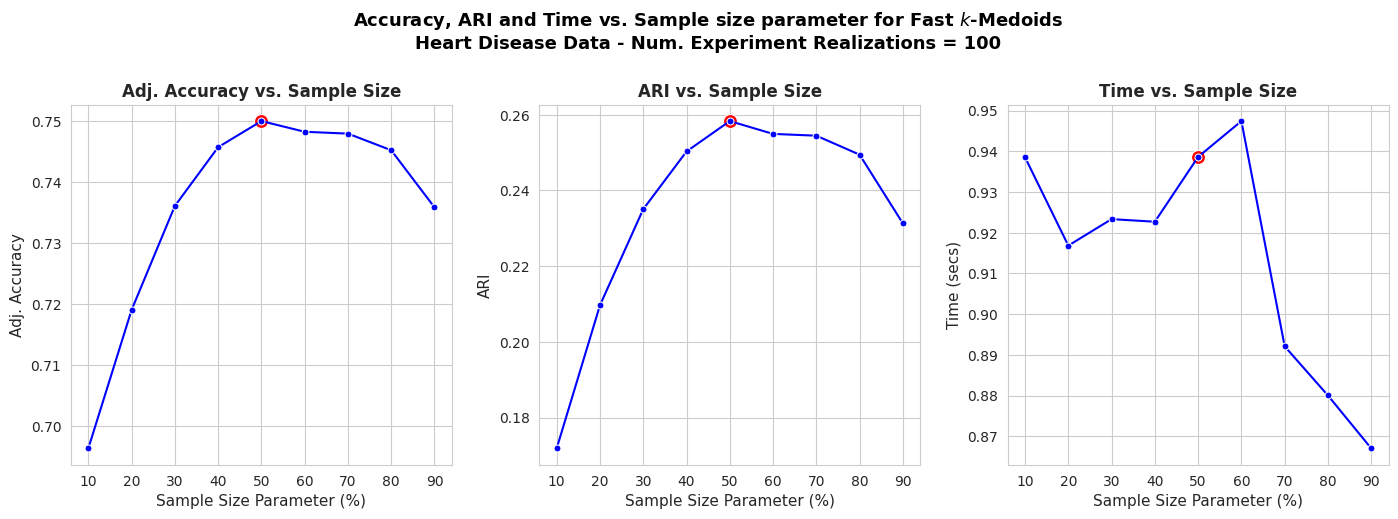

In [38]:
fig, axes = plt.subplots(1, 3, figsize=(17,5))
axes = axes.flatten()  

sns.lineplot(x=[best_frac_sample_size * 100], y=[avg_results['adj_accuracy'][best_frac_sample_size]], color='red', marker='o',  markersize=10, ax=axes[0])
sns.lineplot(
    x=frac_sample_sizes_list * 100,
    y=adj_accuracy_list, 
    color='blue', marker='o',  markersize=5, ax=axes[0]
)

sns.lineplot(x=[best_frac_sample_size * 100], y=[avg_results['ARI'][best_frac_sample_size]], color='red', marker='o',  markersize=10, ax=axes[1])
sns.lineplot(
    x=frac_sample_sizes_list * 100,
    y=ari_list, 
    color='blue', marker='o',  markersize=5, ax=axes[1]
)

sns.lineplot(x=[best_frac_sample_size * 100], y=[avg_results['time'][best_frac_sample_size]], color='red', marker='o', markersize=10, ax=axes[2])
sns.lineplot(
    x=frac_sample_sizes_list * 100,
    y=time_list, 
    color='blue', marker='o', markersize=5, ax=axes[2]
)

axes[0].set_title('Adj. Accuracy vs. Sample Size', size=12, weight='bold')
axes[0].set_ylabel('Adj. Accuracy', size=11)
#axes[0].set_yticks(np.round(np.linspace(np.min(best_accuracy_values), np.max(best_accuracy_values), 7),3))

axes[1].set_title('ARI vs. Sample Size', size=12, weight='bold')
axes[1].set_ylabel('ARI', size=11)
#axes[1].set_yticks(np.round(np.linspace(np.min(best_accuracy_values), np.max(best_accuracy_values), 7),3))

axes[2].set_title('Time vs. Sample Size', size=12, weight='bold')
axes[2].set_ylabel('Time (secs)', size=11)
#axes[2].set_yticks(np.round(np.linspace(np.min(times_values), np.max(times_values), 7),1))

for i in range(len(axes)):
    #axes[i].set_xticks(np.round(np.linspace(np.min(data_perc_sizes), np.max(data_perc_sizes), 7),1))
    axes[i].set_xlabel('Sample Size Parameter (%)', size=11)

#plt.tight_layout()
plt.subplots_adjust(top=0.83)
plt.suptitle('Accuracy, ARI and Time vs. Sample size parameter for Fast $k$-Medoids\nHeart Disease Data - Num. Experiment Realizations = 100', fontsize=13, y=1.02, weight='bold', color='black', alpha=1)
plt.subplots_adjust(hspace=0.5, wspace=0.23) 

plot_filename = f'plot_results_exp_1_german_credit_{file_id}.png'
plot_save_path = os.path.join(results_folder_path, plot_filename)
if not os.path.exists(plot_save_path):
    fig.savefig(plot_save_path, format='png', dpi=300, bbox_inches="tight", pad_inches=0.2)

plt.show()

In [39]:
# Results as table 
avg_results_df = pd.DataFrame(avg_results)
avg_results_df.index.name = 'frac_sample_size'
avg_results_df

,time,adj_accuracy,ARI
frac_sample_size,,,
0.1,0.938533,0.696364,0.171876
0.2,0.916848,0.719057,0.209673
0.3,0.923353,0.736094,0.235058
0.4,0.922712,0.745724,0.250299
0.5,0.938649,0.750000,0.258329
0.6,0.947445,0.748249,0.254944
0.7,0.892089,0.747946,0.254470
0.8,0.880022,0.745219,0.249459
0.9,0.867023,0.735859,0.231306


In [40]:
print(best_frac_sample_size)

0.5



## Experiment 3


In [41]:
run_experiment_3 = True

In [42]:
if run_experiment_3: 

    n_realizations = 100
    experiment_random_state = 123 
    random.seed(experiment_random_state)
    random_state_list = random.sample(range(n_realizations*1000), n_realizations)

    chunk_size = 3
    random_state_list_chunks = split_list_in_chunks(random_state_list, chunk_size=chunk_size)

    results_folder_path = os.path.join(current_path, '..',  '..', 'results', 'results_experiment_3', 'heart_disease')
    os.makedirs(results_folder_path, exist_ok=True)
    file_id = datetime.now(ZoneInfo("Europe/Madrid")).strftime('%Y%m%d_%H%M%S')
    file_id = '20250930_155234'

    config_exp_3 = get_config_exp_3_heart_disease()
    
    config_exp_3.update({
    'n_clusters': n_clusters,
    'p1': p1,
    'p2': p2,
    'p3': p3
    })

    if not isinstance(y, np.ndarray):
        y = y.to_numpy().flatten() # needed by adjusted_accuracy, which is used by make_experiment_1

In [43]:
if run_experiment_3: 

    for chunk_id, random_state_chunk in enumerate(tqdm(random_state_list_chunks, desc='chunks', unit='chunks'), start=0):
        print('random_state_chunk:', random_state_chunk)

        results = {}

        for random_state in random_state_chunk:
            print('random_state:', random_state)    

            results[random_state] = make_experiment_3(**config_exp_3,
                                                    X=X, 
                                                    y=y,
                                                    random_state=random_state,
                                                    metric=accuracy_score
                                                )

        # Save results
        results_filename = f'results_exp_3_heart_disease_chunk_{chunk_id}_{file_id}.pkl'
        results_save_path = os.path.join(results_folder_path, results_filename)
        with open(results_save_path, 'wb') as f:
            pickle.dump(results, f)

# Time 100 realizations:   mins

chunks:   0%|          | 0/34 [00:00<?, ?chunks/s]

random_state_chunk: [6863, 35084, 11427]
random_state: 6863
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.56it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.57it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.58it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.27it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.77it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:03<00:00,  1.17s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.02it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:05<00:00,  1.12s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:04<00:00,  1.23it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:05<00:00,  1.08s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:05<00:00,  1.14s/it]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:05<00:00,  1.14s/it]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:05<00:00,  1.15s/it]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:05<00:00,  1.12s/it]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:05<00:00,  1.19it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.82it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.84it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.69it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:06<00:00,  1.04it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.47it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:05<00:00,  1.34it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:05<00:00,  1.29it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:12<00:00,  1.23s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:08<00:00,  1.16it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:13<00:00,  1.36s/it]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:17<00:00,  1.71s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.41it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:08<00:00,  1.22it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:08<00:00,  1.18it/s]


random_state: 35084
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:03<00:00,  1.24s/it]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:03<00:00,  1.12s/it]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.70it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:03<00:00,  1.18s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:03<00:00,  1.02s/it]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.55it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:03<00:00,  1.06s/it]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.59it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.60it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.33it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [02:37<00:00, 31.41s/it]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:04<00:00,  1.08it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:05<00:00,  1.22it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.89it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.92it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.92it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:05<00:00,  1.29it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:05<00:00,  1.21it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.95it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.93it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.94it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.76it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.74it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.94it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.93it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.93it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.95it/s]


random_state: 11427
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.90it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.90it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.88it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.93it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.89it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.91it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.90it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.92it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.91it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.92it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.93it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.74it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.93it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.93it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.94it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.91it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.94it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.93it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.74it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.92it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.75it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.81it/s]


frac_sample_size: 0.9


chunks:   3%|▎         | 1/34 [10:46<5:55:25, 646.24s/chunks]

random_state_chunk: [53377, 34937, 14116]
random_state: 53377
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.88it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.44it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.89it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.88it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.44it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.91it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.88it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.92it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.89it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.69it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.85it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.89it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.70it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:06<00:00,  1.12it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.56it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.88it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.90it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:08<00:00,  1.22it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.56it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.91it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.91it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.49it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.78it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.92it/s]


random_state: 34937
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.86it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.87it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.88it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.87it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.90it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.90it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.91it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.65it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.90it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.90it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:05<00:00,  1.17it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:05<00:00,  1.32it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.93it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.92it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.74it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.46it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.91it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.93it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.93it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.91it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.79it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.94it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.93it/s]


random_state: 14116
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.37it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.47it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.49it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.89it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.90it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.91it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.91it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.44it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.59it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.51it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.90it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.91it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.91it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.93it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.93it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.94it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.93it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.88it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.88it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.92it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:08<00:00,  1.18it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.93it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.79it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.46it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.36it/s]


frac_sample_size: 0.9


chunks:   6%|▌         | 2/34 [17:24<4:26:58, 500.59s/chunks]

random_state_chunk: [5000, 49692, 70281]
random_state: 5000
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.85it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.81it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.87it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.54it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.12it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.39it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.85it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.89it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.68it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.92it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.93it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.93it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.72it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.75it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.92it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.94it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.95it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:08<00:00,  1.14it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.90it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.92it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.62it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.93it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.81it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.94it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.78it/s]


random_state: 49692
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.87it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.89it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.43it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.68it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.48it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.38it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.57it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.88it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.91it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.69it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.82it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.73it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.92it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.93it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.93it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.94it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.93it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.78it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.93it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.87it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.89it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.29it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.88it/s]


random_state: 70281
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.84it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.83it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.84it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.84it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.86it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.15it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.10it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.27it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.33it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.44it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.53it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.71it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.70it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.89it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.92it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.93it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.92it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.93it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.92it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.92it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.60it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.90it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.58it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:09<00:00,  1.08it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.90it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.89it/s]


frac_sample_size: 0.9


chunks:   9%|▉         | 3/34 [24:02<3:54:25, 453.73s/chunks]

random_state_chunk: [73704, 43541, 44669]
random_state: 73704
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.86it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.85it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.90it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.88it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.90it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.91it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.89it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.89it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.33it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.92it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.92it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.89it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.92it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.91it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.92it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.72it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.92it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.77it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.90it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.92it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.63it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.66it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.93it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.94it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.94it/s]


random_state: 43541
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.51it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.83it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.89it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.89it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.89it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.50it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.16it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.07it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.55it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:04<00:00,  1.25it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.33it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.51it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.74it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.92it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.92it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:05<00:00,  1.31it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.90it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.71it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.92it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.15it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.16it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.94it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.20it/s]


random_state: 44669
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.13it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.13it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.25it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.16it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.26it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.15it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.98it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.18it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.98it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.59it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.12it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.14it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.92it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.14it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.16it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.93it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.20it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


frac_sample_size: 0.9


chunks:  12%|█▏        | 4/34 [30:18<3:31:24, 422.83s/chunks]

random_state_chunk: [6802, 20927, 17702]
random_state: 6802
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.12it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.13it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.13it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.13it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.48it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.09it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.14it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.17it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.98it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.69it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.13it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.07it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.13it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.12it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.43it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.47it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.45it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.62it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.20it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.62it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.78it/s]


random_state: 20927
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.60it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.56it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.10it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.11it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.15it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.13it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.15it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.18it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.10it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.72it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.11it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.12it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.14it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.12it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.14it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:05<00:00,  1.30it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.44it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.16it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.15it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.16it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.12it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


random_state: 17702
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.09it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.10it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.11it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.10it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.14it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.62it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.14it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.10it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.12it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.12it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.97it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.07it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.92it/s]


frac_sample_size: 0.9


chunks:  15%|█▍        | 5/34 [36:10<3:11:58, 397.20s/chunks]

random_state_chunk: [44199, 73526, 43751]
random_state: 44199
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.08it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.61it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.38it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.27it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.43it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.14it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.16it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.18it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.85it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.51it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.11it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.90it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.14it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.14it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.78it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.15it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


random_state: 73526
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.09it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.11it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.13it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.09it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.16it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.15it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.66it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.10it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.08it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.08it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.08it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.02it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.57it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.67it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.08it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.09it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.09it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.09it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.77it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.11it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.09it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.08it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.90it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.88it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.02it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.13it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


random_state: 43751
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.10it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.13it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.09it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.14it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.15it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.14it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.17it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.17it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.19it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.88it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.94it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.79it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.48it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.49it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.14it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:08<00:00,  1.21it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.61it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.14it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.16it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.48it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.14it/s]


frac_sample_size: 0.9


chunks:  18%|█▊        | 6/34 [42:07<2:59:05, 383.78s/chunks]

random_state_chunk: [91971, 32134, 21466]
random_state: 91971
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.10it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.10it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.64it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.13it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.14it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.15it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.14it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.14it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:06<00:00,  1.06it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.72it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.19it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.10it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.04it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


random_state: 32134
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.11it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.13it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.11it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.14it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.15it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.15it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.16it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.17it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.88it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.98it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.72it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.19it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.19it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.11it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.28it/s]


random_state: 21466
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.53it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.57it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.11it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.11it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.58it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.10it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.13it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.15it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:04<00:00,  1.24it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.41it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.13it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.13it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.19it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.14it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.15it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.16it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.16it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.16it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.16it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


frac_sample_size: 0.9


chunks:  21%|██        | 7/34 [47:50<2:46:41, 370.44s/chunks]

random_state_chunk: [218, 57183, 11483]
random_state: 218
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.31it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.14it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.13it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.11it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.15it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.15it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.14it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.18it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.12it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.20it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.19it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.96it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.16it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.16it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


random_state: 57183
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.08it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.11it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.15it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.16it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.14it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.15it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.16it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.12it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.14it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.14it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.85it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:05<00:00,  1.18it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.02it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.33it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.67it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.16it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.89it/s]


random_state: 11483
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.48it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.09it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.09it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.09it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.13it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.14it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.15it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.12it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.19it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.19it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:08<00:00,  1.24it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.07it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.12it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.20it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.20it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.01it/s]


frac_sample_size: 0.9


chunks:  24%|██▎       | 8/34 [53:32<2:36:33, 361.30s/chunks]

random_state_chunk: [78328, 49492, 9158]
random_state: 78328
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.13it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.14it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.14it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.16it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.17it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.16it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.18it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.19it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.19it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.19it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.19it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.20it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.20it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.20it/s]


random_state: 49492
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.96it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.62it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.15it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.18it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.17it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.33it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:04<00:00,  1.16it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.12it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.12it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:05<00:00,  1.22it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.41it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.12it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.14it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:05<00:00,  1.39it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


random_state: 9158
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.08it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.09it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.09it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.10it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.11it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.09it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.10it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.11it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.11it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.10it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:04<00:00,  1.07it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:05<00:00,  1.00s/it]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.12it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.13it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.88it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.20it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.01it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


frac_sample_size: 0.9


chunks:  26%|██▋       | 9/34 [59:11<2:27:36, 354.27s/chunks]

random_state_chunk: [864, 41347, 95949]
random_state: 864
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.63it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.13it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.13it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.15it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.15it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.15it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.17it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.18it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.14it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.14it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.13it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.13it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.14it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.12it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.13it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.92it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.06it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.04it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:08<00:00,  1.25it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.15it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.15it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.49it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.31it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.16it/s]


random_state: 41347
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.10it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.11it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.11it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.44it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.52it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.09it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.73it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.11it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.13it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.12it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.14it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.14it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.14it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.13it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.65it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.33it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.14it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.14it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


random_state: 95949
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.11it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.13it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.14it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.14it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.16it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.16it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.17it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


frac_sample_size: 0.9


chunks:  29%|██▉       | 10/34 [1:04:52<2:20:04, 350.18s/chunks]

random_state_chunk: [58762, 13374, 5752]
random_state: 58762
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.13it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.14it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.13it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.16it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.98it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.15it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.12it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.12it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:04<00:00,  1.15it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.14it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.74it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:05<00:00,  1.24it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.80it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.14it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.93it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.60it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.16it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.15it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.16it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.16it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


random_state: 13374
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.09it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.10it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.10it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.13it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.14it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.14it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.15it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.12it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.12it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.32it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:04<00:00,  1.10it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.91it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.19it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.16it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.20it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


random_state: 5752
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.11it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.14it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.13it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.15it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.15it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.17it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.17it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.19it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.19it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.08it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.16it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:08<00:00,  1.24it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.10it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.10it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.56it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


frac_sample_size: 0.9


chunks:  32%|███▏      | 11/34 [1:10:39<2:13:55, 349.35s/chunks]

random_state_chunk: [12158, 87443, 18635]
random_state: 12158
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.02it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.98it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.61it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.07it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.49it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.31it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.09it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.09it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.09it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.09it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.09it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.10it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.09it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.09it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.11it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.10it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.57it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.06it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.11it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.13it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.13it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.13it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.12it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.84it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.57it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.53it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.14it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.89it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.96it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.12it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.10it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.15it/s]


random_state: 87443
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.60it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.56it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.09it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.07it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.10it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.09it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.13it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.73it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.09it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.10it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.08it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.10it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.09it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.09it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.12it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.13it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.13it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.14it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.14it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.87it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.12it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.13it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.95it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.16it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.16it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.96it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.96it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.88it/s]


random_state: 18635
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.62it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.08it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.37it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.11it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.04it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.08it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.08it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.08it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.08it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.03it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.08it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.27it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:04<00:00,  1.24it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.09it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.05it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.91it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:05<00:00,  1.38it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.12it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.12it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.13it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.14it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.13it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.13it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.12it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.13it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.93it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.12it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.12it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.13it/s]


frac_sample_size: 0.9


chunks:  35%|███▌      | 12/34 [1:16:35<2:08:46, 351.22s/chunks]

random_state_chunk: [16547, 2783, 38247]
random_state: 16547
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.50it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.13it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.13it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.06it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.10it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.07it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.04it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.09it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.10it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.82it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.09it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.10it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.12it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.10it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.88it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.09it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.77it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.88it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.90it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.10it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.11it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.14it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.13it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.09it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.13it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.14it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.14it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.12it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.14it/s]


random_state: 2783
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.06it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.05it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.04it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.09it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.09it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.09it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.14it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.16it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.09it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.75it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:05<00:00,  1.24it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.94it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.83it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.27it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.15it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.12it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.01it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.61it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.70it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


random_state: 38247
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.09it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.08it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.06it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.59it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.15it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.15it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.17it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.18it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.93it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.45it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:05<00:00,  1.18it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.13it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.19it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.16it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


frac_sample_size: 0.9


chunks:  38%|███▊      | 13/34 [1:22:25<2:02:49, 350.94s/chunks]

random_state_chunk: [56444, 75157, 62511]
random_state: 56444
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.08it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.55it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.59it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.65it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.13it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.62it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.17it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.12it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.70it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.13it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.14it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.62it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.63it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.83it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.16it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.94it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.10it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.71it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.61it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


random_state: 75157
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.63it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.09it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.30it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.21it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.03it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.17it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.96it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.26it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.14it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.82it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.91it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.16it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.99it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.96it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.36it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.99it/s]


random_state: 62511
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.58it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.63it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.62it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.14it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.15it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.16it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.16it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.10it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.14it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.16it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.15it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.15it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.14it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.14it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.95it/s]


frac_sample_size: 0.9


chunks:  41%|████      | 14/34 [1:28:13<1:56:39, 349.98s/chunks]

random_state_chunk: [34776, 61511, 4816]
random_state: 34776
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.53it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.11it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.10it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.59it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.15it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.16it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.05it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.17it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.99it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.07it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.12it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.82it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.26it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.73it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.84it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:05<00:00,  1.29it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.68it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.94it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.14it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.86it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.62it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.72it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.16it/s]


random_state: 61511
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.59it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.09it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.09it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.15it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.60it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.81it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:04<00:00,  1.17it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.19it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.04it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.07it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.94it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.13it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


random_state: 4816
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.65it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.13it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.14it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.16it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.15it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.63it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.90it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.90it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.51it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.83it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.33it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.15it/s]


frac_sample_size: 0.9


chunks:  44%|████▍     | 15/34 [1:34:07<1:51:13, 351.22s/chunks]

random_state_chunk: [39989, 45018, 68376]
random_state: 39989
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.10it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.09it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.66it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.61it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.51it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.13it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.15it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.16it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.09it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.14it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.13it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.90it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.74it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.51it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.13it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.94it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.14it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.15it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.89it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.69it/s]


random_state: 45018
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.07it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.11it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.09it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.60it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.13it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.13it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.13it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.15it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.11it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.11it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.12it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.71it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.65it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.14it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.13it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.84it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.91it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.13it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.92it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.14it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.14it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.99it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.73it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.95it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.08it/s]


random_state: 68376
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.01it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.10it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.58it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.72it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.25it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.25it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.67it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.11it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.08it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.12it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.26it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.29it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.11it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.01it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.89it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.14it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.52it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.68it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.15it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.13it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.93it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.96it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.15it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.14it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.13it/s]


frac_sample_size: 0.9


chunks:  47%|████▋     | 16/34 [1:40:03<1:45:46, 352.60s/chunks]

random_state_chunk: [63302, 27113, 79810]
random_state: 63302
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.08it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.58it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.16it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.11it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.13it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.52it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.06it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.16it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.12it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.82it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.83it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.13it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.14it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.70it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.15it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.15it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.12it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.86it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.13it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.14it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.16it/s]


random_state: 27113
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.09it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.11it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.58it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.11it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.14it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.04it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.09it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.11it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.82it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.82it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.10it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.04it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.11it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.74it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.41it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:05<00:00,  1.30it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.11it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.16it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.45it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.56it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.07it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.11it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.45it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.15it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.16it/s]


random_state: 79810
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.09it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.10it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.58it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.95it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.08it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.04it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.13it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.16it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.10it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.12it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.12it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.00it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.81it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.12it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.51it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:06<00:00,  1.17it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.09it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.13it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.09it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.13it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.90it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.16it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.15it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.13it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.08it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.13it/s]


frac_sample_size: 0.9


chunks:  50%|█████     | 17/34 [1:45:58<1:40:10, 353.54s/chunks]

random_state_chunk: [83723, 69084, 74031]
random_state: 83723
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.07it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.10it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.09it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.13it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.10it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.05it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.09it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.11it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.10it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.12it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.75it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.11it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.14it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.14it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.90it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.13it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.16it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.99it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.88it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.25it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.15it/s]


random_state: 69084
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.56it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.63it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.57it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.10it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.09it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.13it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.00it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.06it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.08it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.66it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.39it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.65it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.86it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.78it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.14it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.13it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.14it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.13it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.14it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.15it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.14it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.14it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.14it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.82it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.16it/s]


random_state: 74031
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.08it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.09it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.11it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.59it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.03it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.13it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.11it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.17it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.11it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.12it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.61it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.12it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.79it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.12it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.12it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.13it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.12it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.91it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.13it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.14it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.93it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.13it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.15it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.14it/s]


frac_sample_size: 0.9


chunks:  53%|█████▎    | 18/34 [1:51:51<1:34:09, 353.12s/chunks]

random_state_chunk: [41322, 1644, 52197]
random_state: 41322
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.08it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.10it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.08it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.08it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.13it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.64it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.13it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.07it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.71it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.10it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.86it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.69it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.09it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:05<00:00,  1.38it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:05<00:00,  1.23it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.09it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.73it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.81it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.13it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.85it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.15it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.93it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.80it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.14it/s]


random_state: 1644
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.10it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.09it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.64it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.14it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.14it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.13it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.15it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:04<00:00,  1.16it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.56it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.07it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.11it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.11it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.91it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.92it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.90it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  2.00it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.96it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.96it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


random_state: 52197
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.09it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.67it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.13it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.15it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.16it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.16it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.12it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.14it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.83it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.92it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.69it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.16it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.31it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.80it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.14it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.85it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:08<00:00,  1.20it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


frac_sample_size: 0.9


chunks:  56%|█████▌    | 19/34 [1:57:50<1:28:43, 354.93s/chunks]

random_state_chunk: [84692, 67207, 56935]
random_state: 84692
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.08it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.03it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.68it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.37it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.23it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.60it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.16it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.16it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.10it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.14it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.79it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:08<00:00,  1.21it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.15it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.16it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.01it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.20it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.20it/s]


random_state: 67207
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.09it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.10it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.64it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.13it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.07it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.16it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.15it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.61it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.67it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.93it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.15it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.13it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.01it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.03it/s]


random_state: 56935
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.60it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.13it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.13it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.14it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.13it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.16it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.33it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.28it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.08it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.27it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.28it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.80it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.14it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.55it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.85it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.16it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.16it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.01it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.16it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.99it/s]


frac_sample_size: 0.9


chunks:  59%|█████▉    | 20/34 [2:03:37<1:22:17, 352.69s/chunks]

random_state_chunk: [89762, 70584, 83670]
random_state: 89762
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.11it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.11it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.11it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.13it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.16it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.44it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:04<00:00,  1.14it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.19it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.20it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.78it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.64it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.13it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.16it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  2.00it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


random_state: 70584
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.11it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.62it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.09it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.13it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.63it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.15it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.17it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.19it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.19it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.14it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.12it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.02it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.91it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:05<00:00,  1.19it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.96it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.11it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.14it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:08<00:00,  1.24it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.88it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.10it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.15it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.58it/s]


random_state: 83670
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.05it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.08it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.10it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.14it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.15it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.13it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.12it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.12it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.09it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.12it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.10it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.13it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.82it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.10it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:05<00:00,  1.26it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.55it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.12it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.16it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


frac_sample_size: 0.9


chunks:  62%|██████▏   | 21/34 [2:09:22<1:15:53, 350.30s/chunks]

random_state_chunk: [87380, 78185, 63718]
random_state: 87380
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.04it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.55it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.03it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.66it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.15it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.16it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.16it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.15it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.14it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.15it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.16it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


random_state: 78185
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.11it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.22it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.25it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.60it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.16it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.16it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.96it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:04<00:00,  1.07it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:04<00:00,  1.14it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.96it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:05<00:00,  1.35it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.12it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.15it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


random_state: 63718
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.57it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.11it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.69it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.15it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.15it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.83it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.13it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.16it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.19it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.19it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.19it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.19it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.15it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


frac_sample_size: 0.9


chunks:  65%|██████▍   | 22/34 [2:15:01<1:09:24, 347.03s/chunks]

random_state_chunk: [68237, 87617, 54984]
random_state: 68237
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.91it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.13it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.14it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.13it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.15it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.16it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.15it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.04it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.11it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.14it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.01it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:05<00:00,  1.30it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.20it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.16it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.68it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.68it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.92it/s]


random_state: 87617
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.11it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.13it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.13it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.67it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.15it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.15it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.16it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.62it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:05<00:00,  1.29it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.49it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.89it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.16it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


random_state: 54984
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.10it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.13it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.13it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.13it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.15it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.17it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.17it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.12it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.91it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.19it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.91it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.19it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  2.00it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.09it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.93it/s]


frac_sample_size: 0.9


chunks:  68%|██████▊   | 23/34 [2:20:41<1:03:11, 344.70s/chunks]

random_state_chunk: [49089, 66855, 4173]
random_state: 49089
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.23it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.10it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.10it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.08it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.10it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.58it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.13it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.09it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.33it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.37it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.61it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.20it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.70it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.42it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.86it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.93it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.88it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.42it/s]


random_state: 66855
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.34it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.08it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.10it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.13it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.15it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.16it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.16it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.17it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.09it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.13it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.60it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.15it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.12it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


random_state: 4173
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.09it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.10it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.14it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.14it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.14it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.16it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.17it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:05<00:00,  1.31it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.91it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.42it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.70it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.16it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.67it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.81it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


frac_sample_size: 0.9


chunks:  71%|███████   | 24/34 [2:26:29<57:36, 345.67s/chunks]  

random_state_chunk: [98850, 84600, 23784]
random_state: 98850
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.13it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.14it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.15it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.15it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.17it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.17it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.61it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:05<00:00,  1.26it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.50it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.10it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.89it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.96it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.95it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.15it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.03it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


random_state: 84600
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.11it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.10it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.14it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.13it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.15it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.16it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.15it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.17it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.71it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.92it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.92it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.88it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.92it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.09it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.16it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.14it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.11it/s]


random_state: 23784
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.49it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.05it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.09it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.10it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.91it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.26it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.32it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.03it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.11it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.12it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.45it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.72it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.12it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.84it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.12it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.83it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.16it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.91it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.14it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.14it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.15it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.35it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.60it/s]


frac_sample_size: 0.9


chunks:  74%|███████▎  | 25/34 [2:32:20<52:05, 347.33s/chunks]

random_state_chunk: [95135, 10827, 63819]
random_state: 95135
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.05it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.10it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.62it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.11it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.13it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.17it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.15it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.15it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.13it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.89it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.62it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.70it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


random_state: 10827
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.11it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.13it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.14it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.15it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.14it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.71it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.17it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.65it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:05<00:00,  1.27it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.07it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.13it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.13it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.47it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:05<00:00,  1.37it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.75it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.14it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.16it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.85it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.80it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.93it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.16it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.15it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.16it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


random_state: 63819
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.10it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.10it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.07it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.13it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.15it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.15it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.68it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:04<00:00,  1.09it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.12it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.14it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.12it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.11it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.14it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.16it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.13it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.16it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.15it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.16it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.16it/s]


frac_sample_size: 0.9


chunks:  76%|███████▋  | 26/34 [2:38:04<46:11, 346.47s/chunks]

random_state_chunk: [86255, 34326, 22298]
random_state: 86255
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.10it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.62it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.14it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.15it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.15it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.15it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.67it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.08it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.11it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.12it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.09it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.14it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.14it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.14it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.13it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.81it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.16it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.11it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.32it/s]


random_state: 34326
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.19it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.10it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.14it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.10it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.11it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.06it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.13it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.11it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.58it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.65it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.14it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.91it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.14it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.11it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.12it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.89it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.16it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.66it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:08<00:00,  1.24it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.08it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


random_state: 22298
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.68it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.13it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.14it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.14it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.64it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.15it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.17it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.12it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.92it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.92it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.20it/s]


frac_sample_size: 0.9


chunks:  79%|███████▉  | 27/34 [2:43:47<40:17, 345.38s/chunks]

random_state_chunk: [43896, 44160, 72640]
random_state: 43896
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.70it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.08it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.11it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.62it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.16it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.16it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.16it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.01it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.59it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:04<00:00,  1.12it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.98it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.19it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:06<00:00,  1.13it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.44it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.93it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.80it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.66it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.92it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.95it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.90it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.15it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


random_state: 44160
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.10it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.08it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.61it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.15it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.15it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.61it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.10it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:04<00:00,  1.16it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:04<00:00,  1.15it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.09it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.12it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.86it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.13it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.13it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.87it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.15it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.16it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


random_state: 72640
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.10it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.10it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.11it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.14it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.14it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.13it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.16it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.11it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.13it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.85it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.80it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.85it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.30it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.93it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.13it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.74it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.34it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.16it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.01it/s]


frac_sample_size: 0.9


chunks:  82%|████████▏ | 28/34 [2:49:42<34:50, 348.36s/chunks]

random_state_chunk: [51274, 9606, 94779]
random_state: 51274
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.45it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.08it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.09it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.10it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.16it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.15it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.16it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.17it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.89it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.41it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.51it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.11it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.94it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.96it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.96it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.16it/s]


random_state: 9606
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.09it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.08it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.11it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.14it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.14it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.61it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.18it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.65it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.69it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.84it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.11it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.03it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.86it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.16it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.93it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.96it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.12it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.82it/s]


random_state: 94779
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.10it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.08it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.03it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.12it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.00it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.07it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.10it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.11it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.12it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.10it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.45it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.10it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.61it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.77it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.12it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.14it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.13it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.16it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


frac_sample_size: 0.9


chunks:  85%|████████▌ | 29/34 [2:55:29<28:59, 347.85s/chunks]

random_state_chunk: [59869, 50810, 75126]
random_state: 59869
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.44it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.03it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.14it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.63it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.11it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.13it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.17it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.14it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.14it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.13it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.91it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.09it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.71it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.16it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.87it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


random_state: 50810
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.10it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.13it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.13it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.15it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.16it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.17it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.12it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.07it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:05<00:00,  1.18it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.14it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.12it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.63it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.25it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.15it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.81it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.72it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.78it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.12it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.11it/s]


random_state: 75126
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.07it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.08it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.62it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.11it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.11it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.11it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.15it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.16it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.10it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.12it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.12it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.12it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.73it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.68it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.09it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.14it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:05<00:00,  1.17it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.61it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.13it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.94it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.15it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.16it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


frac_sample_size: 0.9


chunks:  88%|████████▊ | 30/34 [3:01:20<23:14, 348.67s/chunks]

random_state_chunk: [44054, 2137, 24780]
random_state: 44054
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.10it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.09it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.09it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.60it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.13it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.10it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.17it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.10it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.12it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.86it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.11it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.16it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.65it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.48it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


random_state: 2137
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.07it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.13it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.04it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.26it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:02<00:00,  1.25it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.86it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.12it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.41it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.14it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.91it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.89it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:07<00:00,  1.41it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.66it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


random_state: 24780
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.03it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.06it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.13it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.13it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.15it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.15it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.14it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.19it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.16it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.99it/s]


frac_sample_size: 0.9


chunks:  91%|█████████ | 31/34 [3:07:00<17:18, 346.24s/chunks]

random_state_chunk: [76834, 11554, 82354]
random_state: 76834
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.11it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.13it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.14it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.14it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.16it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.16it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.17it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.12it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.10it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.09it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.78it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:05<00:00,  1.36it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.14it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.05it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:05<00:00,  1.37it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.53it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.13it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.15it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.58it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.85it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.15it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.92it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.92it/s]


random_state: 11554
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.08it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.07it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.09it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.62it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.14it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.13it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.14it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.12it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.82it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.12it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.12it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.29it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:06<00:00,  1.16it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.13it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.14it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.83it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.92it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.14it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


random_state: 82354
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.11it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.13it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.14it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.14it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.16it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.63it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.16it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.12it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.85it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.14it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.12it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.82it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.16it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.12it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.65it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.70it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.91it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.77it/s]


frac_sample_size: 0.9


chunks:  94%|█████████▍| 32/34 [3:12:53<11:36, 348.28s/chunks]

random_state_chunk: [47646, 1681, 46126]
random_state: 47646
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.67it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.05it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.10it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.11it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.14it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.14it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.15it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.15it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.56it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.11it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.11it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.12it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.13it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.93it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.63it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:06<00:00,  1.48it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.16it/s]


random_state: 1681
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.80it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.08it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.14it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.10it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.13it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.06it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.07it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.72it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.13it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:04<00:00,  1.73it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  1.92it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.16it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  2.00it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.20it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


random_state: 46126
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.11it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.13it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.11it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.15it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.16it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.98it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.13it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.28it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.08it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.14it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:05<00:00,  1.36it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:05<00:00,  1.21it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.09it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.14it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:05<00:00,  1.27it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.14it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.83it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:05<00:00,  1.96it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.16it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.16it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


frac_sample_size: 0.9


chunks:  97%|█████████▋| 33/34 [3:18:40<05:47, 347.69s/chunks]

random_state_chunk: [30032]
random_state: 30032
n_splits: 3
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.10it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.08it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.11it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.13it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  1.59it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.15it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 3/3 [00:01<00:00,  2.17it/s]


n_splits: 5
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.67it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 5/5 [00:04<00:00,  1.16it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.32it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.11it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]


n_splits: 7
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.12it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.14it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]


frac_sample_size: 0.9


Clustering Folds: 100%|██████████| 7/7 [00:03<00:00,  2.19it/s]


n_splits: 10
frac_sample_size: 0.2


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


frac_sample_size: 0.3


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


frac_sample_size: 0.4


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


frac_sample_size: 0.5


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


frac_sample_size: 0.6


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


frac_sample_size: 0.7


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


frac_sample_size: 0.8


Clustering Folds: 100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


frac_sample_size: 0.9


chunks: 100%|██████████| 34/34 [3:20:33<00:00, 353.92s/chunks]


In [44]:
if run_experiment_3: 

    # Open results by chunk
    chunk_ids = range(len(random_state_list_chunks))
    file_id = '20250930_155234'
    results_chunk = {}
    for chunk_id in chunk_ids:
        results_filename = f'results_exp_3_heart_disease_chunk_{chunk_id}_{file_id}.pkl'
        results_save_path = os.path.join(results_folder_path, results_filename)
        with open(results_save_path, 'rb') as f:
            results_chunk[chunk_id] = pickle.load(f)

    # Join results by chunks
    results = {}
    for i in chunk_ids:
        results.update(results_chunk[i])  

    # Save joined/merged results 
    results_filename = f'results_exp_3_heart_disease_{file_id}.pkl'
    results_save_path = os.path.join(results_folder_path, results_filename)
    with open(results_save_path, 'wb') as f:
        pickle.dump(results, f)

In [45]:
# Open merged/joined results 

file_id = '20250930_155234'
results_filename = f'results_exp_3_heart_disease_{file_id}.pkl'
results_folder_path = os.path.join(current_path, '..',  '..', 'results', 'results_experiment_3', 'heart_disease')
results_save_path = os.path.join(results_folder_path, results_filename)
with open(results_save_path, 'rb') as f:
    results = pickle.load(f)

In [46]:
config_exp_3 = get_config_exp_3_heart_disease()

pivoted_results = get_pivoted_results_two_iterables(results = results, 
                                  iterable1 = config_exp_3['n_splits'], 
                                  iterable2 = config_exp_3['frac_sample_sizes'])

avg_results = get_avg_results_two_iterables(results = results, 
                                  pivoted_results = pivoted_results, 
                                  iterable1 = config_exp_3['n_splits'], 
                                  iterable2 = config_exp_3['frac_sample_sizes'])

dfs = avg_results_to_dfs(avg_results, column_1='n_splits', column_2='frac_sample_sizes')

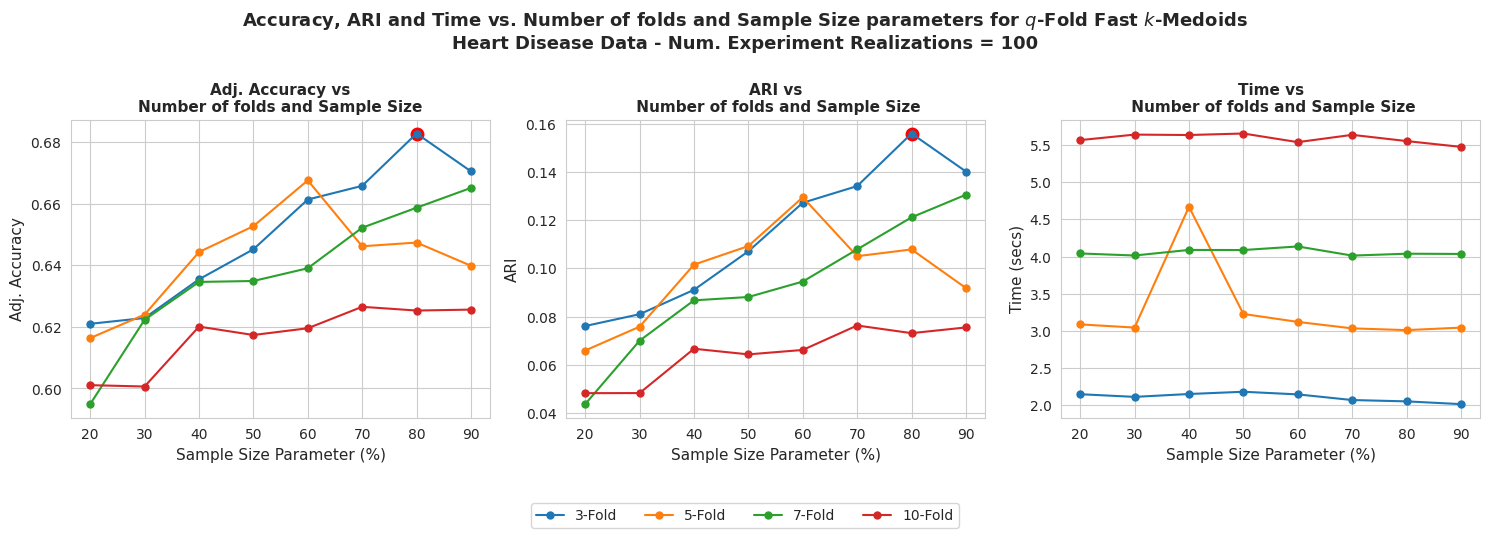

In [47]:
best_combi_acc = dfs['adj_accuracy'].sort_values(by='adj_accuracy', ascending=False).iloc[0]
best_combi_ari = dfs['ARI'].sort_values(by='ARI', ascending=False).iloc[0]
best_combi_time = dfs['time'].sort_values(by='time', ascending=True).iloc[0]

fig, axes = plt.subplots(1, 3, figsize=(15, 5.5), sharex=True)

# Primer subplot: Accuracy
ax1 = axes[0]
ax1.plot(best_combi_acc['frac_sample_sizes'] * 100, best_combi_acc['adj_accuracy'], marker='o', markersize=9, color='red')
for k1 in sorted(dfs['adj_accuracy']['n_splits'].unique()):
    subset = dfs['adj_accuracy'][dfs['adj_accuracy']['n_splits'] == k1]
    ax1.plot(subset['frac_sample_sizes'] * 100, subset['adj_accuracy'], marker='o', markersize=5, label=f"{k1}-Fold")
ax1.set_title("Adj. Accuracy vs\nNumber of folds and Sample Size", fontsize=11, fontweight='bold')
ax1.set_xlabel("Sample Size Parameter (%)", size=11)
ax1.set_ylabel("Adj. Accuracy", size=11)

# Segundo subplot: Accuracy
ax2 = axes[1]
ax2.plot(best_combi_ari['frac_sample_sizes'] * 100, best_combi_ari['ARI'], marker='o', markersize=9, color='red')
for k1 in sorted(dfs['ARI']['n_splits'].unique()):
    subset = dfs['ARI'][dfs['ARI']['n_splits'] == k1]
    ax2.plot(subset['frac_sample_sizes'] * 100, subset['ARI'], marker='o', markersize=5, label=f"{k1}-Fold")
ax2.set_title("ARI vs\n Number of folds and Sample Size", fontsize=11, fontweight='bold')
ax2.set_xlabel("Sample Size Parameter (%)", size=11)
ax2.set_ylabel("ARI", size=11)

# Tercer subplot: Time
ax3 = axes[2]
#ax3.plot(best_combi_time['frac_sample_sizes'] * 100, best_combi_time['time'], marker='o', markersize=9, color='red')
for k1 in sorted(dfs['time']['n_splits'].unique()):
    subset = dfs['time'][dfs['time']['n_splits'] == k1]
    ax3.plot(subset['frac_sample_sizes'] * 100, subset['time'], marker='o', markersize=5, label=f"{k1}-Fold")
ax3.set_title("Time vs\n Number of folds and Sample Size", fontsize=11, fontweight='bold')
ax3.set_xlabel("Sample Size Parameter (%)", size=11)
ax3.set_ylabel("Time (secs)", size=11)

# Título general
fig.suptitle("Accuracy, ARI and Time vs. Number of folds and Sample Size parameters for $q$-Fold Fast $k$-Medoids\nHeart Disease Data - Num. Experiment Realizations = 100", fontsize=13, fontweight='bold', y=0.95)

# Leyenda común abajo
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=len(labels), fontsize=10)

plt.tight_layout(rect=[0, 0.1, 1, 0.95])

plot_filename = f'plot_results_exp_3_heart_disease_{file_id}.png'
plot_save_path = os.path.join(results_folder_path, plot_filename)
fig.savefig(plot_save_path, format='png', dpi=300, bbox_inches="tight", pad_inches=0.2)

plt.show()

In [48]:
# Results as table
avg_results_df = pd.concat([dfs['adj_accuracy'], dfs['ARI']['ARI'], dfs['time']['time']], axis=1)
avg_results_df

,n_splits,frac_sample_sizes,adj_accuracy,ARI,time
0,3,0.2,0.621010,0.076071,2.146862
1,3,0.3,0.622896,0.080965,2.110856
2,3,0.4,0.635455,0.091103,2.149413
3,3,0.5,0.645219,0.107134,2.179837
4,3,0.6,0.661380,0.127286,2.144264
5,3,0.7,0.665825,0.134215,2.068363
6,3,0.8,0.682828,0.156068,2.050357
7,3,0.9,0.670539,0.140260,2.013154
8,5,0.2,0.616364,0.065889,3.086619
9,5,0.3,0.624007,0.075792,3.044053


In [49]:
n = len(X)
split_ratio = np.round((best_combi_acc['n_splits']/n)*100,3) # best_split = split_ratio * n

print(' split_ratio', split_ratio, '\n', 'best_n_splits', best_combi_acc['n_splits'], '\n', 'best_frac_sample_size', best_combi_acc['frac_sample_sizes'])

 split_ratio 1.01 
 best_n_splits 3.0 
 best_frac_sample_size 0.8



## Experiment 4

In [50]:
config_exp_4 = get_config_exp_4_heart_disease()
    
config_exp_4.update({
    'n_clusters': n_clusters,
    'p1': p1,
    'p2': p2,
    'p3': p3
    })

if not isinstance(y, np.ndarray):
    y = y.to_numpy().flatten() # needed by adjusted_accuracy, which is used by make_experiment_4

quant_distances_names = ['robust_mahalanobis']
binary_distances_names = ['jaccard', 'sokal']
multiclass_distances_names = ['hamming']
robust_method = ['MAD', 'trimmed', 'winsorized']

GGower_distances_names = get_GGower_distances_names(quant_distances_names, binary_distances_names, multiclass_distances_names, robust_method)

#################################################################################################

# With real data the realizations cannot operate over the randomness of the data
# An alternative approach is to operate over the randomness of the models.

models = {}
n_realizations = 100
experiment_random_state = 123 
random.seed(experiment_random_state)
random_state_list = random.sample(range(n_realizations*1000), n_realizations)

for random_state in random_state_list:

    models[random_state] = {
        
        'KMeans': KMeans(
            n_clusters=config_exp_4['n_clusters'], 
            random_state=random_state, 
            init='k-means++', 
            n_init='auto', 
            max_iter=config_exp_4['max_iter']),

        'CLARA': CLARA(n_clusters=config_exp_4['n_clusters'], 
                       metric='euclidean',
                       random_state=random_state),

        'Diana': Diana(n_clusters=config_exp_4['n_clusters']),

        'LDAKmeans': LDAKmeans(n_clusters=config_exp_4['n_clusters'], random_state=random_state),

        'SubKmeans': SubKmeans(n_clusters=config_exp_4['n_clusters']),

        'GaussianMixture': GaussianMixture(n_components=config_exp_4['n_clusters'], 
                                           random_state=random_state),

        'AgglomerativeClustering': AgglomerativeClustering(n_clusters=config_exp_4['n_clusters']),

        'SpectralBiclustering': SpectralBiclustering(n_clusters=config_exp_4['n_clusters'], random_state=random_state),

        'SpectralCoclustering': SpectralCoclustering(n_clusters=config_exp_4['n_clusters'], random_state=random_state),

        'Birch': Birch(n_clusters=config_exp_4['n_clusters']),

        'BisectingKMeans': BisectingKMeans(n_clusters=config_exp_4['n_clusters'], 
                                        random_state=random_state, 
                                        max_iter=config_exp_4['max_iter']),

        'MiniBatchKMeans': MiniBatchKMeans(n_clusters=config_exp_4['n_clusters'], 
                                        random_state=random_state, 
                                        max_iter=config_exp_4['max_iter']),

        'KMedoids-euclidean': KMedoids(n_clusters=config_exp_4['n_clusters'], 
                                    metric='euclidean', 
                                    method=config_exp_4['method'], 
                                    init=config_exp_4['init'], 
                                    max_iter=config_exp_4['max_iter'], 
                                    random_state=random_state),

        'DipInit': DipInit(n_clusters=config_exp_4['n_clusters'],
                            random_state=random_state),

        'SpectralClustering': SpectralClustering(n_clusters=config_exp_4['n_clusters'],
                                                 random_state=random_state)

 
    }

    #################################################################################################

    for d in GGower_distances_names:

        d1, d2, d3 = d.split('-')

        if 'robust' in d1:
            r = d1.split('_')[-1]
            d1 = '_'.join(d1.split('_')[:2])
            
        models[random_state][f'FastKmedoidsGGower-{d1}_{r}-{d2}-{d3}'] = FastKmedoidsGGower(
                n_clusters=config_exp_4['n_clusters'], 
                method=config_exp_4['method'], 
                init=config_exp_4['init'], 
                max_iter=config_exp_4['max_iter'], 
                random_state=random_state,
                frac_sample_size=config_exp_4['frac_sample_size_fast_kmedoids'], 
                p1=config_exp_4['p1'], 
                p2=config_exp_4['p2'], 
                p3=config_exp_4['p3'], 
                d1=d1, 
                d2=d2, 
                d3=d3, 
                robust_method=r, 
                alpha=config_exp_4['alpha'], 
                epsilon=config_exp_4['epsilon'], 
                n_iters=config_exp_4['n_iters'],
                VG_sample_size=config_exp_4['VG_sample_size'], 
                VG_n_samples=config_exp_4['VG_n_samples']) 

        models[random_state][f'FoldFastKmedoidsGGower-{d1}_{r}-{d2}-{d3}'] = FoldFastKmedoidsGGower(
                n_clusters=config_exp_4['n_clusters'], 
                method=config_exp_4['method'], 
                init=config_exp_4['init'], 
                max_iter=config_exp_4['max_iter'], 
                random_state=random_state,
                frac_sample_size=config_exp_4['frac_sample_size_fold_fast_kmedoids'], 
                p1=config_exp_4['p1'], 
                p2=config_exp_4['p2'], 
                p3=config_exp_4['p3'], 
                d1=d1, 
                d2=d2, 
                d3=d3, 
                robust_method=r, 
                alpha=config_exp_4['alpha'], 
                epsilon=config_exp_4['epsilon'], 
                n_iters=config_exp_4['n_iters'],
                VG_sample_size=config_exp_4['VG_sample_size'], 
                VG_n_samples=config_exp_4['VG_n_samples'],
                n_splits=config_exp_4['n_splits'], 
                shuffle=config_exp_4['shuffle'], 
                kfold_random_state=random_state) 

In [51]:
run_experiment_4 = True

In [52]:
if run_experiment_4: 

    chunk_size = 3
    random_state_list_chunks = split_list_in_chunks(random_state_list, chunk_size=chunk_size)

    results_folder_path = os.path.join(current_path, '..',  '..', 'results', 'results_experiment_4', 'heart_disease')
    os.makedirs(results_folder_path, exist_ok=True)
    file_id = datetime.now(ZoneInfo("Europe/Madrid")).strftime('%Y%m%d_%H%M%S')
    file_id = '20251001_121615'

    X_pd = X.to_pandas() # Some models like LDAKmeans expect Pandas

In [53]:
if run_experiment_4: 
 
    for chunk_id, random_state_chunk in enumerate(tqdm(random_state_list_chunks, desc='chunks', unit='chunks'), start=0):
        print('chunk_id', chunk_id)
        print('random_state_chunk:', random_state_chunk)

        results = {}

        for random_state in random_state_chunk:
            print('random_state:', random_state)        
            
            results[random_state] = make_experiment_4(
                X=X_pd, 
                y=y, 
                models=models[random_state],
                metric=accuracy_score)

        # Save results
        results_filename = f'results_exp_4_heart_disease_chunk_{chunk_id}_{file_id}.pkl'
        results_save_path = os.path.join(results_folder_path, results_filename)
        with open(results_save_path, 'wb') as f:
            pickle.dump(results, f)

# Time 100 realizations:  mins

chunks:   0%|          | 0/34 [00:00<?, ?chunks/s]

chunk_id 0
random_state_chunk: [6863, 35084, 11427]
random_state: 6863
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited at iteration 84 with accuracies 
[9.20542261e-05 3.91815743e-06 1.20737457e-03]
not reaching the requested tolerance 4.425644874572754e-06.
Use iteration 84 instead with accuracy 
0.00043444898311179947.

  _, diffusion_map = lobpcg(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited postprocessing with accuracies 
[9.20542261e-05 3.91815659e-06 1.20737457e-03]
not reaching the requested tolerance 4.425644874572754e-06.
  _, diffusion_map = lobpcg(


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.10it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.52it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.82it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


len y_pred: 2
random_state: 35084
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited at iteration 54 with accuracies 
[1.87527665e-11 8.31788332e-06 3.74261719e-06]
not reaching the requested tolerance 4.425644874572754e-06.
Use iteration 34 instead with accuracy 
3.372894519232664e-06.

  _, diffusion_map = lobpcg(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited postprocessing with accuracies 
[9.23713332e-12 8.50846519e-07 9.26782771e-06]
not reaching the requested tolerance 4.425644874572754e-06.
  _, diffusion_map = lobpcg(


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.67it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.53it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


len y_pred: 2
random_state: 11427
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited at iteration 42 with accuracies 
[2.83082786e-06 3.23819360e-04 2.58844241e-04]
not reaching the requested tolerance 4.425644874572754e-06.
Use iteration 42 instead with accuracy 
0.00019516480951768518.

  _, diffusion_map = lobpcg(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited postprocessing with accuracies 
[2.83082786e-06 3.23819360e-04 2.58844241e-04]
not reaching the requested tolerance 4.425644874572754e-06.
  _, diffusion_map = lobpcg(


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.68it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.96it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:   3%|▎         | 1/34 [01:26<47:23, 86.17s/chunks]

len y_pred: 2
chunk_id 1
random_state_chunk: [53377, 34937, 14116]
random_state: 53377
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited at iteration 107 with accuracies 
[3.08477155e-04 3.38123950e-06 1.39661383e-03]
not reaching the requested tolerance 4.425644874572754e-06.
Use iteration 95 instead with accuracy 
0.00019498910540948646.

  _, diffusion_map = lobpcg(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited postprocessing with accuracies 
[1.41862951e-04 5.69059031e-06 4.37413776e-04]
not reaching the requested tolerance 4.425644874572754e-06.
  _, diffusion_map = lobpcg(


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.22it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.36it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.57it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


len y_pred: 2
random_state: 34937
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.74it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.57it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


len y_pred: 2
random_state: 14116
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited at iteration 41 with accuracies 
[2.95576398e-06 2.42996565e-04 2.34863053e-04]
not reaching the requested tolerance 4.425644874572754e-06.
Use iteration 41 instead with accuracy 
0.0001602717940790057.

  _, diffusion_map = lobpcg(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited postprocessing with accuracies 
[2.95576398e-06 2.42996565e-04 2.34863053e-04]
not reaching the requested tolerance 4.425644874572754e-06.
  _, diffusion_map = lobpcg(


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.80it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.51it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:   6%|▌         | 2/34 [02:52<46:04, 86.39s/chunks]

len y_pred: 2
chunk_id 2
random_state_chunk: [5000, 49692, 70281]
random_state: 5000
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited at iteration 39 with accuracies 
[2.09919499e-06 2.61608109e-06 4.34808031e-05]
not reaching the requested tolerance 4.425644874572754e-06.
Use iteration 39 instead with accuracy 
1.6065359738871565e-05.

  _, diffusion_map = lobpcg(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited postprocessing with accuracies 
[2.09919897e-06 2.61607785e-06 4.34808031e-05]
not reaching the requested tolerance 4.425644874572754e-06.
  _, diffusion_map = lobpcg(


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.63it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.19it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.42it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:04<00:00,  1.15it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.99it/s]


len y_pred: 2
random_state: 49692
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited at iteration 23 with accuracies 
[2.15022592e-06 3.89438574e-06 8.70939417e-04]
not reaching the requested tolerance 4.425644874572754e-06.
Use iteration 23 instead with accuracy 
0.00029232800961148306.

  _, diffusion_map = lobpcg(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited postprocessing with accuracies 
[2.15022673e-06 3.89438530e-06 8.70939417e-04]
not reaching the requested tolerance 4.425644874572754e-06.
  _, diffusion_map = lobpcg(


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.73it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.98it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.55it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.53it/s]


len y_pred: 2
random_state: 70281
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited at iteration 43 with accuracies 
[2.28333307e-06 3.02950123e-04 6.43609612e-04]
not reaching the requested tolerance 4.425644874572754e-06.
Use iteration 43 instead with accuracy 
0.0003162810225308494.

  _, diffusion_map = lobpcg(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited postprocessing with accuracies 
[2.28333307e-06 3.02950123e-04 6.43609612e-04]
not reaching the requested tolerance 4.425644874572754e-06.
  _, diffusion_map = lobpcg(


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.71it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.76it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:   9%|▉         | 3/34 [04:19<44:39, 86.44s/chunks]

len y_pred: 2
chunk_id 3
random_state_chunk: [73704, 43541, 44669]
random_state: 73704
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.93it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.19it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.55it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


len y_pred: 2
random_state: 43541
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.70it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.20it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.19it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.58it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


len y_pred: 2
random_state: 44669
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited at iteration 39 with accuracies 
[4.37397813e-06 3.23147380e-04 5.01685514e-04]
not reaching the requested tolerance 4.425644874572754e-06.
Use iteration 39 instead with accuracy 
0.0002764022907546775.

  _, diffusion_map = lobpcg(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited postprocessing with accuracies 
[4.37397813e-06 3.23147380e-04 5.01685514e-04]
not reaching the requested tolerance 4.425644874572754e-06.
  _, diffusion_map = lobpcg(


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.68it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.54it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  12%|█▏        | 4/34 [05:40<42:11, 84.38s/chunks]

len y_pred: 2
chunk_id 4
random_state_chunk: [6802, 20927, 17702]
random_state: 6802
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited at iteration 78 with accuracies 
[7.08438571e-05 3.65834480e-06 1.18773404e-03]
not reaching the requested tolerance 4.425644874572754e-06.
Use iteration 78 instead with accuracy 
0.0004207454147088782.

  _, diffusion_map = lobpcg(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited postprocessing with accuracies 
[7.08438572e-05 3.65834466e-06 1.18773404e-03]
not reaching the requested tolerance 4.425644874572754e-06.
  _, diffusion_map = lobpcg(


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.86it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.55it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.39it/s]


len y_pred: 2
random_state: 20927
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.79it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.45it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.70it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.11it/s]


len y_pred: 2
random_state: 17702
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.70it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:04<00:00,  1.23it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.47it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.12it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  15%|█▍        | 5/34 [07:15<42:38, 88.22s/chunks]

len y_pred: 2
chunk_id 5
random_state_chunk: [44199, 73526, 43751]
random_state: 44199
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.08it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.61it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


len y_pred: 2
random_state: 73526
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.06it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.20it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.20it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.61it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


len y_pred: 2
random_state: 43751
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.60it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.57it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  18%|█▊        | 6/34 [08:35<39:55, 85.57s/chunks]

len y_pred: 2
chunk_id 6
random_state_chunk: [91971, 32134, 21466]
random_state: 91971
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.98it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.19it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.57it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


len y_pred: 2
random_state: 32134
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited at iteration 43 with accuracies 
[3.94710094e-06 3.29638610e-04 1.99787081e-04]
not reaching the requested tolerance 4.425644874572754e-06.
Use iteration 43 instead with accuracy 
0.0001777909305788098.

  _, diffusion_map = lobpcg(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited postprocessing with accuracies 
[3.94710094e-06 3.29638610e-04 1.99787081e-04]
not reaching the requested tolerance 4.425644874572754e-06.
  _, diffusion_map = lobpcg(


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.19it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.19it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.59it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


len y_pred: 2
random_state: 21466
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited at iteration 30 with accuracies 
[4.36499436e-06 3.17179435e-04 2.18373823e-02]
not reaching the requested tolerance 4.425644874572754e-06.
Use iteration 30 instead with accuracy 
0.007386308912763624.

  _, diffusion_map = lobpcg(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited postprocessing with accuracies 
[4.36499436e-06 3.17179435e-04 2.18373823e-02]
not reaching the requested tolerance 4.425644874572754e-06.
  _, diffusion_map = lobpcg(


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.72it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.65it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.56it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  21%|██        | 7/34 [09:57<37:56, 84.31s/chunks]

len y_pred: 2
chunk_id 7
random_state_chunk: [218, 57183, 11483]
random_state: 218
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited at iteration 42 with accuracies 
[3.21053494e-06 2.83173742e-04 1.26027963e-04]
not reaching the requested tolerance 4.425644874572754e-06.
Use iteration 42 instead with accuracy 
0.00013747074693780303.

  _, diffusion_map = lobpcg(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited postprocessing with accuracies 
[3.21053494e-06 2.83173742e-04 1.26027963e-04]
not reaching the requested tolerance 4.425644874572754e-06.
  _, diffusion_map = lobpcg(


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.95it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.19it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.55it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


len y_pred: 2
random_state: 57183
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited at iteration 33 with accuracies 
[1.24094633e-12 7.90087399e-06 4.02769493e-06]
not reaching the requested tolerance 4.425644874572754e-06.
Use iteration 33 instead with accuracy 
3.9761900557606874e-06.

  _, diffusion_map = lobpcg(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited postprocessing with accuracies 
[1.22408517e-12 7.90087282e-06 4.02769724e-06]
not reaching the requested tolerance 4.425644874572754e-06.
  _, diffusion_map = lobpcg(


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.61it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.56it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.69it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.10it/s]


len y_pred: 2
random_state: 11483
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited at iteration 64 with accuracies 
[1.33689518e-04 3.51733418e-06 2.69502272e-03]
not reaching the requested tolerance 4.425644874572754e-06.
Use iteration 45 instead with accuracy 
0.0005391735421279779.

  _, diffusion_map = lobpcg(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited postprocessing with accuracies 
[2.68781461e-04 3.52013976e-05 1.31353777e-03]
not reaching the requested tolerance 4.425644874572754e-06.
  _, diffusion_map = lobpcg(


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.01it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.53it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.12it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  24%|██▎       | 8/34 [11:21<36:27, 84.12s/chunks]

len y_pred: 2
chunk_id 8
random_state_chunk: [78328, 49492, 9158]
random_state: 78328
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.67it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.19it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.58it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.68it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.67it/s]


len y_pred: 2
random_state: 49492
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.94it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.19it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.19it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.57it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


len y_pred: 2
random_state: 9158
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited at iteration 39 with accuracies 
[3.78874560e-06 3.82350161e-04 7.13672204e-04]
not reaching the requested tolerance 4.425644874572754e-06.
Use iteration 39 instead with accuracy 
0.00036660370373346637.

  _, diffusion_map = lobpcg(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited postprocessing with accuracies 
[3.78874560e-06 3.82350161e-04 7.13672204e-04]
not reaching the requested tolerance 4.425644874572754e-06.
  _, diffusion_map = lobpcg(


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.66it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.55it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  26%|██▋       | 9/34 [12:49<35:31, 85.24s/chunks]

len y_pred: 2
chunk_id 9
random_state_chunk: [864, 41347, 95949]
random_state: 864
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited at iteration 39 with accuracies 
[1.14213680e-06 3.91933998e-06 8.85370019e-04]
not reaching the requested tolerance 4.425644874572754e-06.
Use iteration 39 instead with accuracy 
0.0002968104986093242.

  _, diffusion_map = lobpcg(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited postprocessing with accuracies 
[1.14213699e-06 3.91933993e-06 8.85370019e-04]
not reaching the requested tolerance 4.425644874572754e-06.
  _, diffusion_map = lobpcg(


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.56it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


len y_pred: 2
random_state: 41347
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited at iteration 50 with accuracies 
[2.20817393e-11 7.85462858e-06 2.31239446e-06]
not reaching the requested tolerance 4.425644874572754e-06.
Use iteration 38 instead with accuracy 
2.7092166689699503e-06.

  _, diffusion_map = lobpcg(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited postprocessing with accuracies 
[1.91931978e-12 2.63084128e-06 5.49681893e-06]
not reaching the requested tolerance 4.425644874572754e-06.
  _, diffusion_map = lobpcg(


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.69it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.19it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.58it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


len y_pred: 2
random_state: 95949
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited at iteration 42 with accuracies 
[2.35188736e-06 3.16150043e-04 3.39333211e-04]
not reaching the requested tolerance 4.425644874572754e-06.
Use iteration 42 instead with accuracy 
0.0002192783806880466.

  _, diffusion_map = lobpcg(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited postprocessing with accuracies 
[2.35188736e-06 3.16150043e-04 3.39333211e-04]
not reaching the requested tolerance 4.425644874572754e-06.
  _, diffusion_map = lobpcg(


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.59it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.55it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  29%|██▉       | 10/34 [14:12<33:56, 84.84s/chunks]

len y_pred: 2
chunk_id 10
random_state_chunk: [58762, 13374, 5752]
random_state: 58762
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited at iteration 38 with accuracies 
[4.01780699e-06 3.90908954e-04 8.49011707e-04]
not reaching the requested tolerance 4.425644874572754e-06.
Use iteration 38 instead with accuracy 
0.00041464615601766457.

  _, diffusion_map = lobpcg(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited postprocessing with accuracies 
[4.01780699e-06 3.90908954e-04 8.49011707e-04]
not reaching the requested tolerance 4.425644874572754e-06.
  _, diffusion_map = lobpcg(


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.74it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.04it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.57it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


len y_pred: 2
random_state: 13374
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.06it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.19it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.19it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.57it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


len y_pred: 2
random_state: 5752
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited at iteration 41 with accuracies 
[2.88351567e-06 2.77095037e-04 2.82009859e-04]
not reaching the requested tolerance 4.425644874572754e-06.
Use iteration 41 instead with accuracy 
0.0001873294704941676.

  _, diffusion_map = lobpcg(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited postprocessing with accuracies 
[2.88351567e-06 2.77095037e-04 2.82009859e-04]
not reaching the requested tolerance 4.425644874572754e-06.
  _, diffusion_map = lobpcg(


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.09it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.30it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  32%|███▏      | 11/34 [15:33<32:01, 83.54s/chunks]

len y_pred: 2
chunk_id 11
random_state_chunk: [12158, 87443, 18635]
random_state: 12158
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.83it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.70it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.30it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.54it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


len y_pred: 2
random_state: 87443
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.54it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.12it/s]


len y_pred: 2
random_state: 18635
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited at iteration 64 with accuracies 
[8.08808158e-05 4.31100568e-06 2.10293285e-03]
not reaching the requested tolerance 4.425644874572754e-06.
Use iteration 51 instead with accuracy 
0.00023236499328494232.

  _, diffusion_map = lobpcg(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited postprocessing with accuracies 
[9.77738434e-05 6.04768279e-05 5.38844309e-04]
not reaching the requested tolerance 4.425644874572754e-06.
  _, diffusion_map = lobpcg(


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.66it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.59it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.54it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.12it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  35%|███▌      | 12/34 [17:03<31:23, 85.62s/chunks]

len y_pred: 2
chunk_id 12
random_state_chunk: [16547, 2783, 38247]
random_state: 16547
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited at iteration 41 with accuracies 
[3.73282831e-06 4.46470771e-04 4.52380566e-04]
not reaching the requested tolerance 4.425644874572754e-06.
Use iteration 41 instead with accuracy 
0.000300861388428858.

  _, diffusion_map = lobpcg(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited postprocessing with accuracies 
[3.73282831e-06 4.46470771e-04 4.52380566e-04]
not reaching the requested tolerance 4.425644874572754e-06.
  _, diffusion_map = lobpcg(


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.98it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.11it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.47it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.10it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.10it/s]


len y_pred: 2
random_state: 2783
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.43it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:04<00:00,  1.14it/s]


len y_pred: 2
random_state: 38247
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.70it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.53it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  38%|███▊      | 13/34 [18:29<29:55, 85.50s/chunks]

len y_pred: 2
chunk_id 13
random_state_chunk: [56444, 75157, 62511]
random_state: 56444
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited at iteration 42 with accuracies 
[3.37907927e-06 1.96462912e-04 5.05500665e-04]
not reaching the requested tolerance 4.425644874572754e-06.
Use iteration 42 instead with accuracy 
0.00023511421866129344.

  _, diffusion_map = lobpcg(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited postprocessing with accuracies 
[3.37907927e-06 1.96462912e-04 5.05500665e-04]
not reaching the requested tolerance 4.425644874572754e-06.
  _, diffusion_map = lobpcg(


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.37it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.50it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.11it/s]


len y_pred: 2
random_state: 75157
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited at iteration 40 with accuracies 
[4.32959291e-06 4.76639489e-04 4.47883880e-04]
not reaching the requested tolerance 4.425644874572754e-06.
Use iteration 40 instead with accuracy 
0.0003096176542625943.

  _, diffusion_map = lobpcg(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited postprocessing with accuracies 
[4.32959291e-06 4.76639489e-04 4.47883880e-04]
not reaching the requested tolerance 4.425644874572754e-06.
  _, diffusion_map = lobpcg(


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.74it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.58it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


len y_pred: 2
random_state: 62511
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited at iteration 38 with accuracies 
[4.17637016e-06 1.32982864e-06 4.92182124e-05]
not reaching the requested tolerance 4.425644874572754e-06.
Use iteration 38 instead with accuracy 
1.8241470402845484e-05.

  _, diffusion_map = lobpcg(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited postprocessing with accuracies 
[4.17636994e-06 1.32982893e-06 4.92182124e-05]
not reaching the requested tolerance 4.425644874572754e-06.
  _, diffusion_map = lobpcg(


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.95it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.53it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  41%|████      | 14/34 [19:50<28:02, 84.14s/chunks]

len y_pred: 2
chunk_id 14
random_state_chunk: [34776, 61511, 4816]
random_state: 34776
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited at iteration 41 with accuracies 
[2.76582361e-06 3.37873274e-04 2.78097778e-04]
not reaching the requested tolerance 4.425644874572754e-06.
Use iteration 41 instead with accuracy 
0.00020624562530650823.

  _, diffusion_map = lobpcg(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited postprocessing with accuracies 
[2.76582361e-06 3.37873274e-04 2.78097778e-04]
not reaching the requested tolerance 4.425644874572754e-06.
  _, diffusion_map = lobpcg(


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.64it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.53it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


len y_pred: 2
random_state: 61511
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.93it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.19it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.25it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


len y_pred: 2
random_state: 4816
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited at iteration 48 with accuracies 
[3.80132890e-12 1.61156824e-05 3.09745623e-06]
not reaching the requested tolerance 4.425644874572754e-06.
Use iteration 36 instead with accuracy 
5.989740986911386e-06.

  _, diffusion_map = lobpcg(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited postprocessing with accuracies 
[3.80071406e-12 1.24205817e-05 5.54863717e-06]
not reaching the requested tolerance 4.425644874572754e-06.
  _, diffusion_map = lobpcg(


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.05it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.53it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.11it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  44%|████▍     | 15/34 [21:13<26:36, 84.01s/chunks]

len y_pred: 2
chunk_id 15
random_state_chunk: [39989, 45018, 68376]
random_state: 39989
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.63it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.19it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.06it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.30it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.82it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.11it/s]


len y_pred: 2
random_state: 45018
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.60it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.12it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.51it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.11it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.10it/s]


len y_pred: 2
random_state: 68376
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.59it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.48it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  47%|████▋     | 16/34 [22:42<25:35, 85.33s/chunks]

len y_pred: 2
chunk_id 16
random_state_chunk: [63302, 27113, 79810]
random_state: 63302
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited at iteration 40 with accuracies 
[3.62220160e-06 5.31191878e-04 1.52084785e-04]
not reaching the requested tolerance 4.425644874572754e-06.
Use iteration 40 instead with accuracy 
0.00022896628829618002.

  _, diffusion_map = lobpcg(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited postprocessing with accuracies 
[3.62220160e-06 5.31191878e-04 1.52084785e-04]
not reaching the requested tolerance 4.425644874572754e-06.
  _, diffusion_map = lobpcg(


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.97it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:04<00:00,  1.17it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.30it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.49it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


len y_pred: 2
random_state: 27113
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited at iteration 43 with accuracies 
[3.04746070e-06 2.40718144e-04 7.13092637e-04]
not reaching the requested tolerance 4.425644874572754e-06.
Use iteration 41 instead with accuracy 
0.000305531351387472.

  _, diffusion_map = lobpcg(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited postprocessing with accuracies 
[6.94507865e-06 2.43271427e-04 6.66377549e-04]
not reaching the requested tolerance 4.425644874572754e-06.
  _, diffusion_map = lobpcg(


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.74it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.54it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.11it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.12it/s]


len y_pred: 2
random_state: 79810
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited at iteration 40 with accuracies 
[3.64499585e-06 1.96849628e-04 2.27059413e-04]
not reaching the requested tolerance 4.425644874572754e-06.
Use iteration 40 instead with accuracy 
0.0001425180121607959.

  _, diffusion_map = lobpcg(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited postprocessing with accuracies 
[3.64499585e-06 1.96849628e-04 2.27059413e-04]
not reaching the requested tolerance 4.425644874572754e-06.
  _, diffusion_map = lobpcg(


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.08it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.55it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  50%|█████     | 17/34 [24:09<24:18, 85.81s/chunks]

len y_pred: 2
chunk_id 17
random_state_chunk: [83723, 69084, 74031]
random_state: 83723
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited at iteration 43 with accuracies 
[2.87689688e-06 2.00130183e-04 1.13559351e-04]
not reaching the requested tolerance 4.425644874572754e-06.
Use iteration 43 instead with accuracy 
0.00010552214370486841.

  _, diffusion_map = lobpcg(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited postprocessing with accuracies 
[2.87689688e-06 2.00130183e-04 1.13559351e-04]
not reaching the requested tolerance 4.425644874572754e-06.
  _, diffusion_map = lobpcg(


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.77it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.52it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.12it/s]


len y_pred: 2
random_state: 69084
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.73it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.54it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.11it/s]


len y_pred: 2
random_state: 74031
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited at iteration 46 with accuracies 
[2.46390477e-06 3.63339273e-04 6.70414002e-04]
not reaching the requested tolerance 4.425644874572754e-06.
Use iteration 45 instead with accuracy 
0.00034341386674862745.

  _, diffusion_map = lobpcg(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited postprocessing with accuracies 
[5.12028856e-06 3.58835331e-04 6.66285981e-04]
not reaching the requested tolerance 4.425644874572754e-06.
  _, diffusion_map = lobpcg(


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.70it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.54it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  53%|█████▎    | 18/34 [25:29<22:27, 84.22s/chunks]

len y_pred: 2
chunk_id 18
random_state_chunk: [41322, 1644, 52197]
random_state: 41322
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.99it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.53it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.12it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.11it/s]


len y_pred: 2
random_state: 1644
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:04<00:00,  1.23it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.49it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


len y_pred: 2
random_state: 52197
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.95it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.19it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.58it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  56%|█████▌    | 19/34 [26:59<21:26, 85.77s/chunks]

len y_pred: 2
chunk_id 19
random_state_chunk: [84692, 67207, 56935]
random_state: 84692
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited at iteration 24 with accuracies 
[1.59180294e-11 1.25798119e-05 3.23955242e-06]
not reaching the requested tolerance 4.425644874572754e-06.
Use iteration 24 instead with accuracy 
5.2731267557963475e-06.

  _, diffusion_map = lobpcg(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited postprocessing with accuracies 
[1.59179915e-11 1.25798112e-05 3.23955515e-06]
not reaching the requested tolerance 4.425644874572754e-06.
  _, diffusion_map = lobpcg(


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.92it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.19it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.53it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.10it/s]


len y_pred: 2
random_state: 67207
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.68it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.58it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:04<00:00,  1.23it/s]


len y_pred: 2
random_state: 56935
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.74it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.55it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  59%|█████▉    | 20/34 [28:31<20:28, 87.78s/chunks]

len y_pred: 2
chunk_id 20
random_state_chunk: [89762, 70584, 83670]
random_state: 89762
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited at iteration 41 with accuracies 
[4.23256107e-06 4.48303999e-04 4.81345516e-04]
not reaching the requested tolerance 4.425644874572754e-06.
Use iteration 41 instead with accuracy 
0.00031129402553897647.

  _, diffusion_map = lobpcg(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited postprocessing with accuracies 
[4.23256107e-06 4.48303999e-04 4.81345516e-04]
not reaching the requested tolerance 4.425644874572754e-06.
  _, diffusion_map = lobpcg(


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.73it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.97it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.55it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.11it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


len y_pred: 2
random_state: 70584
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited at iteration 43 with accuracies 
[2.94748088e-06 1.64157172e-04 7.19398901e-04]
not reaching the requested tolerance 4.425644874572754e-06.
Use iteration 43 instead with accuracy 
0.00029550118481131153.

  _, diffusion_map = lobpcg(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited postprocessing with accuracies 
[2.94748088e-06 1.64157172e-04 7.19398901e-04]
not reaching the requested tolerance 4.425644874572754e-06.
  _, diffusion_map = lobpcg(


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.75it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.19it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.59it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


len y_pred: 2
random_state: 83670
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited at iteration 39 with accuracies 
[4.12159613e-06 1.46662785e-04 2.65112278e-04]
not reaching the requested tolerance 4.425644874572754e-06.
Use iteration 39 instead with accuracy 
0.0001386322197540368.

  _, diffusion_map = lobpcg(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited postprocessing with accuracies 
[4.12159613e-06 1.46662785e-04 2.65112278e-04]
not reaching the requested tolerance 4.425644874572754e-06.
  _, diffusion_map = lobpcg(


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.19it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.19it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.58it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  62%|██████▏   | 21/34 [29:54<18:41, 86.30s/chunks]

len y_pred: 2
chunk_id 21
random_state_chunk: [87380, 78185, 63718]
random_state: 87380
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited at iteration 42 with accuracies 
[3.44642279e-06 1.74679011e-04 9.61178140e-04]
not reaching the requested tolerance 4.425644874572754e-06.
Use iteration 42 instead with accuracy 
0.0003797678578929997.

  _, diffusion_map = lobpcg(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited postprocessing with accuracies 
[3.44642279e-06 1.74679011e-04 9.61178140e-04]
not reaching the requested tolerance 4.425644874572754e-06.
  _, diffusion_map = lobpcg(


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.97it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.19it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.55it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


len y_pred: 2
random_state: 78185
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited at iteration 42 with accuracies 
[2.97250787e-06 5.12636168e-04 1.67359756e-04]
not reaching the requested tolerance 4.425644874572754e-06.
Use iteration 40 instead with accuracy 
0.00021236208085371935.

  _, diffusion_map = lobpcg(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited postprocessing with accuracies 
[6.17077007e-06 4.52076003e-04 1.78839470e-04]
not reaching the requested tolerance 4.425644874572754e-06.
  _, diffusion_map = lobpcg(


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.67it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.58it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.26it/s]


len y_pred: 2
random_state: 63718
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited at iteration 39 with accuracies 
[4.01219891e-06 2.18289544e-04 2.03618661e-04]
not reaching the requested tolerance 4.425644874572754e-06.
Use iteration 39 instead with accuracy 
0.00014197346813076486.

  _, diffusion_map = lobpcg(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited postprocessing with accuracies 
[4.01219891e-06 2.18289544e-04 2.03618661e-04]
not reaching the requested tolerance 4.425644874572754e-06.
  _, diffusion_map = lobpcg(


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.32it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.22it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.52it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  65%|██████▍   | 22/34 [31:21<17:19, 86.62s/chunks]

len y_pred: 2
chunk_id 22
random_state_chunk: [68237, 87617, 54984]
random_state: 68237
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.67it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.55it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


len y_pred: 2
random_state: 87617
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited at iteration 38 with accuracies 
[2.99388952e-06 5.88581672e-04 4.96696528e-04]
not reaching the requested tolerance 4.425644874572754e-06.
Use iteration 38 instead with accuracy 
0.0003627573634049719.

  _, diffusion_map = lobpcg(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited postprocessing with accuracies 
[2.99388952e-06 5.88581672e-04 4.96696528e-04]
not reaching the requested tolerance 4.425644874572754e-06.
  _, diffusion_map = lobpcg(


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.73it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.55it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


len y_pred: 2
random_state: 54984
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.81it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.53it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  68%|██████▊   | 23/34 [32:47<15:50, 86.42s/chunks]

len y_pred: 2
chunk_id 23
random_state_chunk: [49089, 66855, 4173]
random_state: 49089
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.08it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.52it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.12it/s]


len y_pred: 2
random_state: 66855
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.78it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.52it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.10it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.11it/s]


len y_pred: 2
random_state: 4173
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited at iteration 87 with accuracies 
[1.38122226e-04 3.42398105e-06 1.40604258e-03]
not reaching the requested tolerance 4.425644874572754e-06.
Use iteration 87 instead with accuracy 
0.0005158629298712677.

  _, diffusion_map = lobpcg(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited postprocessing with accuracies 
[1.38122226e-04 3.42398130e-06 1.40604258e-03]
not reaching the requested tolerance 4.425644874572754e-06.
  _, diffusion_map = lobpcg(


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.62it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.53it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  71%|███████   | 24/34 [34:17<14:35, 87.53s/chunks]

len y_pred: 2
chunk_id 24
random_state_chunk: [98850, 84600, 23784]
random_state: 98850
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited at iteration 83 with accuracies 
[1.14719291e-04 2.73912512e-06 2.92610867e-03]
not reaching the requested tolerance 4.425644874572754e-06.
Use iteration 68 instead with accuracy 
0.0009823810895795888.

  _, diffusion_map = lobpcg(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited postprocessing with accuracies 
[1.03626546e-04 1.80860009e-05 2.82543073e-03]
not reaching the requested tolerance 4.425644874572754e-06.
  _, diffusion_map = lobpcg(


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.69it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.56it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


len y_pred: 2
random_state: 84600
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited at iteration 29 with accuracies 
[3.78218738e-06 4.03431797e-04 7.60188849e-03]
not reaching the requested tolerance 4.425644874572754e-06.
Use iteration 29 instead with accuracy 
0.0026697008250532567.

  _, diffusion_map = lobpcg(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited postprocessing with accuracies 
[3.78218738e-06 4.03431797e-04 7.60188849e-03]
not reaching the requested tolerance 4.425644874572754e-06.
  _, diffusion_map = lobpcg(


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.91it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.54it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.12it/s]


len y_pred: 2
random_state: 23784
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited at iteration 39 with accuracies 
[2.84924121e-06 2.46117319e-04 3.50921518e-04]
not reaching the requested tolerance 4.425644874572754e-06.
Use iteration 39 instead with accuracy 
0.00019996269277594274.

  _, diffusion_map = lobpcg(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited postprocessing with accuracies 
[2.84924121e-06 2.46117319e-04 3.50921518e-04]
not reaching the requested tolerance 4.425644874572754e-06.
  _, diffusion_map = lobpcg(


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.04it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.06it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.55it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  74%|███████▎  | 25/34 [35:40<12:53, 85.98s/chunks]

len y_pred: 2
chunk_id 25
random_state_chunk: [95135, 10827, 63819]
random_state: 95135
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited at iteration 42 with accuracies 
[2.03485542e-06 1.33696645e-04 4.32110574e-04]
not reaching the requested tolerance 4.425644874572754e-06.
Use iteration 42 instead with accuracy 
0.0001892806916367969.

  _, diffusion_map = lobpcg(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited postprocessing with accuracies 
[2.03485542e-06 1.33696645e-04 4.32110574e-04]
not reaching the requested tolerance 4.425644874572754e-06.
  _, diffusion_map = lobpcg(


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.92it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.54it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.19it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.39it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.10it/s]


len y_pred: 2
random_state: 10827
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited at iteration 38 with accuracies 
[4.04868518e-06 5.15758362e-04 4.55727418e-04]
not reaching the requested tolerance 4.425644874572754e-06.
Use iteration 38 instead with accuracy 
0.0003251781548746139.

  _, diffusion_map = lobpcg(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited postprocessing with accuracies 
[4.04868518e-06 5.15758362e-04 4.55727418e-04]
not reaching the requested tolerance 4.425644874572754e-06.
  _, diffusion_map = lobpcg(


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.60it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.52it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.11it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.12it/s]


len y_pred: 2
random_state: 63819
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited at iteration 26 with accuracies 
[3.35901256e-06 6.63147779e-07 1.27005162e-03]
not reaching the requested tolerance 4.425644874572754e-06.
Use iteration 26 instead with accuracy 
0.0004246912591051161.

  _, diffusion_map = lobpcg(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited postprocessing with accuracies 
[3.35901141e-06 6.63153606e-07 1.27005162e-03]
not reaching the requested tolerance 4.425644874572754e-06.
  _, diffusion_map = lobpcg(


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.52it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.12it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  76%|███████▋  | 26/34 [37:10<11:37, 87.22s/chunks]

len y_pred: 2
chunk_id 26
random_state_chunk: [86255, 34326, 22298]
random_state: 86255
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited at iteration 39 with accuracies 
[4.19281112e-06 6.83837506e-04 5.04129058e-04]
not reaching the requested tolerance 4.425644874572754e-06.
Use iteration 39 instead with accuracy 
0.00039738645850434805.

  _, diffusion_map = lobpcg(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited postprocessing with accuracies 
[4.19281112e-06 6.83837506e-04 5.04129058e-04]
not reaching the requested tolerance 4.425644874572754e-06.
  _, diffusion_map = lobpcg(


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.60it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.52it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.12it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:04<00:00,  1.15it/s]


len y_pred: 2
random_state: 34326
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.37it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.09it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.32it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.04it/s]


len y_pred: 2
random_state: 22298
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited at iteration 40 with accuracies 
[2.73178657e-06 2.79024967e-04 8.99017043e-04]
not reaching the requested tolerance 4.425644874572754e-06.
Use iteration 40 instead with accuracy 
0.0003935912655768313.

  _, diffusion_map = lobpcg(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited postprocessing with accuracies 
[2.73178657e-06 2.79024967e-04 8.99017043e-04]
not reaching the requested tolerance 4.425644874572754e-06.
  _, diffusion_map = lobpcg(


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.74it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.08it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.09it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.36it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.07it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  79%|███████▉  | 27/34 [38:47<10:30, 90.09s/chunks]

len y_pred: 2
chunk_id 27
random_state_chunk: [43896, 44160, 72640]
random_state: 43896
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited at iteration 24 with accuracies 
[3.36375619e-06 2.09275868e-06 8.26939567e-04]
not reaching the requested tolerance 4.425644874572754e-06.
Use iteration 24 instead with accuracy 
0.0002774653605351995.

  _, diffusion_map = lobpcg(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited postprocessing with accuracies 
[3.36375711e-06 2.09275721e-06 8.26939567e-04]
not reaching the requested tolerance 4.425644874572754e-06.
  _, diffusion_map = lobpcg(


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.64it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.11it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.10it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.38it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.12it/s]


len y_pred: 2
random_state: 44160
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.13it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.54it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.12it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.12it/s]


len y_pred: 2
random_state: 72640
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.70it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.53it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.11it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  82%|████████▏ | 28/34 [40:09<08:47, 87.89s/chunks]

len y_pred: 2
chunk_id 28
random_state_chunk: [51274, 9606, 94779]
random_state: 51274
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited at iteration 41 with accuracies 
[7.68462980e-07 3.40779728e-06 1.04743654e-03]
not reaching the requested tolerance 4.425644874572754e-06.
Use iteration 15 instead with accuracy 
0.0001755965146525174.

  _, diffusion_map = lobpcg(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited postprocessing with accuracies 
[5.23188707e-05 4.96552925e-05 4.24815381e-04]
not reaching the requested tolerance 4.425644874572754e-06.
  _, diffusion_map = lobpcg(


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.60it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.69it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.10it/s]


len y_pred: 2
random_state: 9606
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited at iteration 88 with accuracies 
[6.59246482e-05 2.73097682e-06 8.14190903e-04]
not reaching the requested tolerance 4.425644874572754e-06.
Use iteration 69 instead with accuracy 
0.00025779740721304506.

  _, diffusion_map = lobpcg(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited postprocessing with accuracies 
[1.24903877e-04 2.55931944e-05 6.22895156e-04]
not reaching the requested tolerance 4.425644874572754e-06.
  _, diffusion_map = lobpcg(


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.61it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.28it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.39it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.47it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.12it/s]


len y_pred: 2
random_state: 94779
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited at iteration 38 with accuracies 
[1.19635168e-06 3.23428981e-06 1.57079184e-03]
not reaching the requested tolerance 4.425644874572754e-06.
Use iteration 15 instead with accuracy 
0.0004887045919922675.

  _, diffusion_map = lobpcg(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited postprocessing with accuracies 
[1.17081768e-04 5.92648693e-05 1.28976714e-03]
not reaching the requested tolerance 4.425644874572754e-06.
  _, diffusion_map = lobpcg(


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.73it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.53it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  85%|████████▌ | 29/34 [41:41<07:24, 88.97s/chunks]

len y_pred: 2
chunk_id 29
random_state_chunk: [59869, 50810, 75126]
random_state: 59869
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited at iteration 37 with accuracies 
[2.44799448e-06 3.01761592e-04 8.95666436e-04]
not reaching the requested tolerance 4.425644874572754e-06.
Use iteration 37 instead with accuracy 
0.0003999586744397946.

  _, diffusion_map = lobpcg(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited postprocessing with accuracies 
[2.44799448e-06 3.01761592e-04 8.95666436e-04]
not reaching the requested tolerance 4.425644874572754e-06.
  _, diffusion_map = lobpcg(


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.08it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.51it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


len y_pred: 2
random_state: 50810
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited at iteration 41 with accuracies 
[2.84025642e-06 2.31783759e-04 7.34126037e-04]
not reaching the requested tolerance 4.425644874572754e-06.
Use iteration 41 instead with accuracy 
0.0003229166840279605.

  _, diffusion_map = lobpcg(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited postprocessing with accuracies 
[2.84025642e-06 2.31783759e-04 7.34126037e-04]
not reaching the requested tolerance 4.425644874572754e-06.
  _, diffusion_map = lobpcg(


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.09it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.04it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:04<00:00,  1.17it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.11it/s]


len y_pred: 2
random_state: 75126
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited at iteration 39 with accuracies 
[3.83079977e-06 3.14066102e-04 7.36583391e-04]
not reaching the requested tolerance 4.425644874572754e-06.
Use iteration 39 instead with accuracy 
0.00035149343114292147.

  _, diffusion_map = lobpcg(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited postprocessing with accuracies 
[3.83079977e-06 3.14066102e-04 7.36583391e-04]
not reaching the requested tolerance 4.425644874572754e-06.
  _, diffusion_map = lobpcg(


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.60it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.55it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  88%|████████▊ | 30/34 [43:06<05:50, 87.68s/chunks]

len y_pred: 2
chunk_id 30
random_state_chunk: [44054, 2137, 24780]
random_state: 44054
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.55it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


len y_pred: 2
random_state: 2137
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited at iteration 22 with accuracies 
[9.67996555e-12 8.75111522e-05 1.44839632e-06]
not reaching the requested tolerance 4.425644874572754e-06.
Use iteration 22 instead with accuracy 
2.9653186056900862e-05.

  _, diffusion_map = lobpcg(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited postprocessing with accuracies 
[2.67196657e-12 8.75111519e-05 1.44841340e-06]
not reaching the requested tolerance 4.425644874572754e-06.
  _, diffusion_map = lobpcg(


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.11it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.55it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.12it/s]


len y_pred: 2
random_state: 24780
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited at iteration 41 with accuracies 
[3.65363685e-06 1.21523786e-04 1.86887944e-04]
not reaching the requested tolerance 4.425644874572754e-06.
Use iteration 41 instead with accuracy 
0.0001040217889004192.

  _, diffusion_map = lobpcg(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited postprocessing with accuracies 
[3.65363685e-06 1.21523786e-04 1.86887944e-04]
not reaching the requested tolerance 4.425644874572754e-06.
  _, diffusion_map = lobpcg(


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.93it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.51it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  91%|█████████ | 31/34 [44:27<04:17, 85.74s/chunks]

len y_pred: 2
chunk_id 31
random_state_chunk: [76834, 11554, 82354]
random_state: 76834
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited at iteration 30 with accuracies 
[1.27301556e-06 3.33536959e-06 3.62505007e-03]
not reaching the requested tolerance 4.425644874572754e-06.
Use iteration 17 instead with accuracy 
0.00022035995278184894.

  _, diffusion_map = lobpcg(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited postprocessing with accuracies 
[2.71634317e-05 2.73881781e-05 6.06528249e-04]
not reaching the requested tolerance 4.425644874572754e-06.
  _, diffusion_map = lobpcg(


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.08it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.50it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.11it/s]


len y_pred: 2
random_state: 11554
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited at iteration 38 with accuracies 
[3.89839594e-06 1.09412067e-04 5.12008361e-04]
not reaching the requested tolerance 4.425644874572754e-06.
Use iteration 38 instead with accuracy 
0.00020843960804703543.

  _, diffusion_map = lobpcg(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited postprocessing with accuracies 
[3.89839594e-06 1.09412067e-04 5.12008361e-04]
not reaching the requested tolerance 4.425644874572754e-06.
  _, diffusion_map = lobpcg(


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.89it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.07it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.41it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


len y_pred: 2
random_state: 82354
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited at iteration 42 with accuracies 
[2.40519157e-06 1.09005649e-04 2.19887227e-04]
not reaching the requested tolerance 4.425644874572754e-06.
Use iteration 42 instead with accuracy 
0.00011043268906418336.

  _, diffusion_map = lobpcg(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited postprocessing with accuracies 
[2.40519157e-06 1.09005649e-04 2.19887227e-04]
not reaching the requested tolerance 4.425644874572754e-06.
  _, diffusion_map = lobpcg(


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.08it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:04<00:00,  1.24it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.53it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.34it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.05it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  94%|█████████▍| 32/34 [45:55<02:53, 86.55s/chunks]

len y_pred: 2
chunk_id 32
random_state_chunk: [47646, 1681, 46126]
random_state: 47646
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited at iteration 29 with accuracies 
[3.30873153e-06 1.83126351e-04 1.05962836e-02]
not reaching the requested tolerance 4.425644874572754e-06.
Use iteration 28 instead with accuracy 
0.0035938206435316877.

  _, diffusion_map = lobpcg(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited postprocessing with accuracies 
[5.67105612e-06 1.82826596e-04 1.05929643e-02]
not reaching the requested tolerance 4.425644874572754e-06.
  _, diffusion_map = lobpcg(


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.41it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.09it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.08it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.35it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.05it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


len y_pred: 2
random_state: 1681
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited at iteration 75 with accuracies 
[6.05733165e-05 3.30124411e-06 2.73480342e-03]
not reaching the requested tolerance 4.425644874572754e-06.
Use iteration 75 instead with accuracy 
0.0009328926594582734.

  _, diffusion_map = lobpcg(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited postprocessing with accuracies 
[6.05733165e-05 3.30124474e-06 2.73480342e-03]
not reaching the requested tolerance 4.425644874572754e-06.
  _, diffusion_map = lobpcg(


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.45it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.10it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.11it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.39it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.09it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


len y_pred: 2
random_state: 46126
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited at iteration 41 with accuracies 
[4.15685298e-06 3.23923825e-04 3.56421601e-04]
not reaching the requested tolerance 4.425644874572754e-06.
Use iteration 41 instead with accuracy 
0.00022816742600441264.

  _, diffusion_map = lobpcg(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited postprocessing with accuracies 
[4.15685298e-06 3.23923825e-04 3.56421601e-04]
not reaching the requested tolerance 4.425644874572754e-06.
  _, diffusion_map = lobpcg(


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.73it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:03<00:00,  1.26it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks:  97%|█████████▋| 33/34 [47:23<01:26, 86.95s/chunks]

len y_pred: 2
chunk_id 33
random_state_chunk: [30032]
random_state: 30032
KMeans
len y_pred: 2
CLARA
len y_pred: 2
Diana
len y_pred: 2
LDAKmeans
len y_pred: 2
SubKmeans
len y_pred: 2
GaussianMixture
len y_pred: 2
AgglomerativeClustering
len y_pred: 2
SpectralBiclustering
len y_pred: 2
SpectralCoclustering
len y_pred: 2
Birch
len y_pred: 2
BisectingKMeans
len y_pred: 2
MiniBatchKMeans
len y_pred: 2
KMedoids-euclidean
len y_pred: 2
DipInit
len y_pred: 2
SpectralClustering


/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited at iteration 44 with accuracies 
[3.03017831e-06 4.87434560e-04 1.82585574e-04]
not reaching the requested tolerance 4.425644874572754e-06.
Use iteration 44 instead with accuracy 
0.000224350104087232.

  _, diffusion_map = lobpcg(
/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:453: UserWarning: Exited postprocessing with accuracies 
[3.03017831e-06 4.87434560e-04 1.82585574e-04]
not reaching the requested tolerance 4.425644874572754e-06.
  _, diffusion_map = lobpcg(


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  2.73it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  1.97it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:01<00:00,  3.46it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming


Clustering Folds: 100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


len y_pred: 2
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming
len y_pred: 2
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming


chunks: 100%|██████████| 34/34 [47:51<00:00, 84.45s/chunks]

len y_pred: 2


In [54]:
if run_experiment_4: 

    # Open results by chunk
    chunk_ids = range(len(random_state_list_chunks))
    results_folder_path = os.path.join(current_path, '..', '..', 'results', 'results_experiment_4', 'heart_disease')
    file_id = '20251001_121615'
    results_chunk = {}
    for chunk_id in chunk_ids:
        results_filename = f'results_exp_4_heart_disease_chunk_{chunk_id}_{file_id}.pkl'
        results_save_path = os.path.join(results_folder_path, results_filename)
        with open(results_save_path, 'rb') as f:
            results_chunk[chunk_id] = pickle.load(f)

    # Join results by chunks
    results = {}
    for i in chunk_ids:
        results.update(results_chunk[i])  

    # Save joined/merged results 
    results_filename = f'results_exp_4_heart_disease_{file_id}.pkl'
    results_save_path = os.path.join(results_folder_path, results_filename)
    with open(results_save_path, 'wb') as f:
        pickle.dump(results, f)

In [55]:
# Open merged/joined results 

results_filename = f'results_exp_4_heart_disease_{file_id}.pkl'
results_folder_path = os.path.join(current_path, '..', '..', 'results', 'results_experiment_4', 'heart_disease')
results_save_path = os.path.join(results_folder_path, results_filename)
with open(results_save_path, 'rb') as f:
    results = pickle.load(f)

In [56]:
model_names = list(models[random_state_list[0]].keys())

pivoted_results = get_pivoted_results(
    results=results, 
    iterable=model_names
)

avg_results = get_avg_results(
    results=results, 
    pivoted_results=pivoted_results, 
    iterable=model_names
)

In [57]:
not_feasible_methods = [] 

for model_name in not_feasible_methods:
    avg_results['adj_labels'][model_name] = None
    avg_results['labels'][model_name] = None
    avg_results['adj_accuracy'][model_name] = 0
    avg_results['ARI'][model_name] = 0
    avg_results['time'][model_name] = 0

model_names = np.array(list(avg_results['adj_accuracy'].keys()))
avg_adj_accuracy = np.array(list(avg_results['adj_accuracy'].values()))
avg_ari = np.array(list(avg_results['ARI'].values()))
avg_time = np.array(list(avg_results['time'].values()))
idx_sorted = np.argsort(-avg_adj_accuracy) 
#idx_sorted = np.argsort(-avg_ari) 

our_methods_1 = [x for x in model_names if 'Fast' in x and 'Fold' not in x] # Fast k-medoids
our_methods_2 = [x for x in model_names if 'Fast' in x and 'Fold' in x] # q-Fold Fast k-medoids
other_methods = [x for x in model_names if x not in our_methods_1 + our_methods_2 and x not in not_feasible_methods]

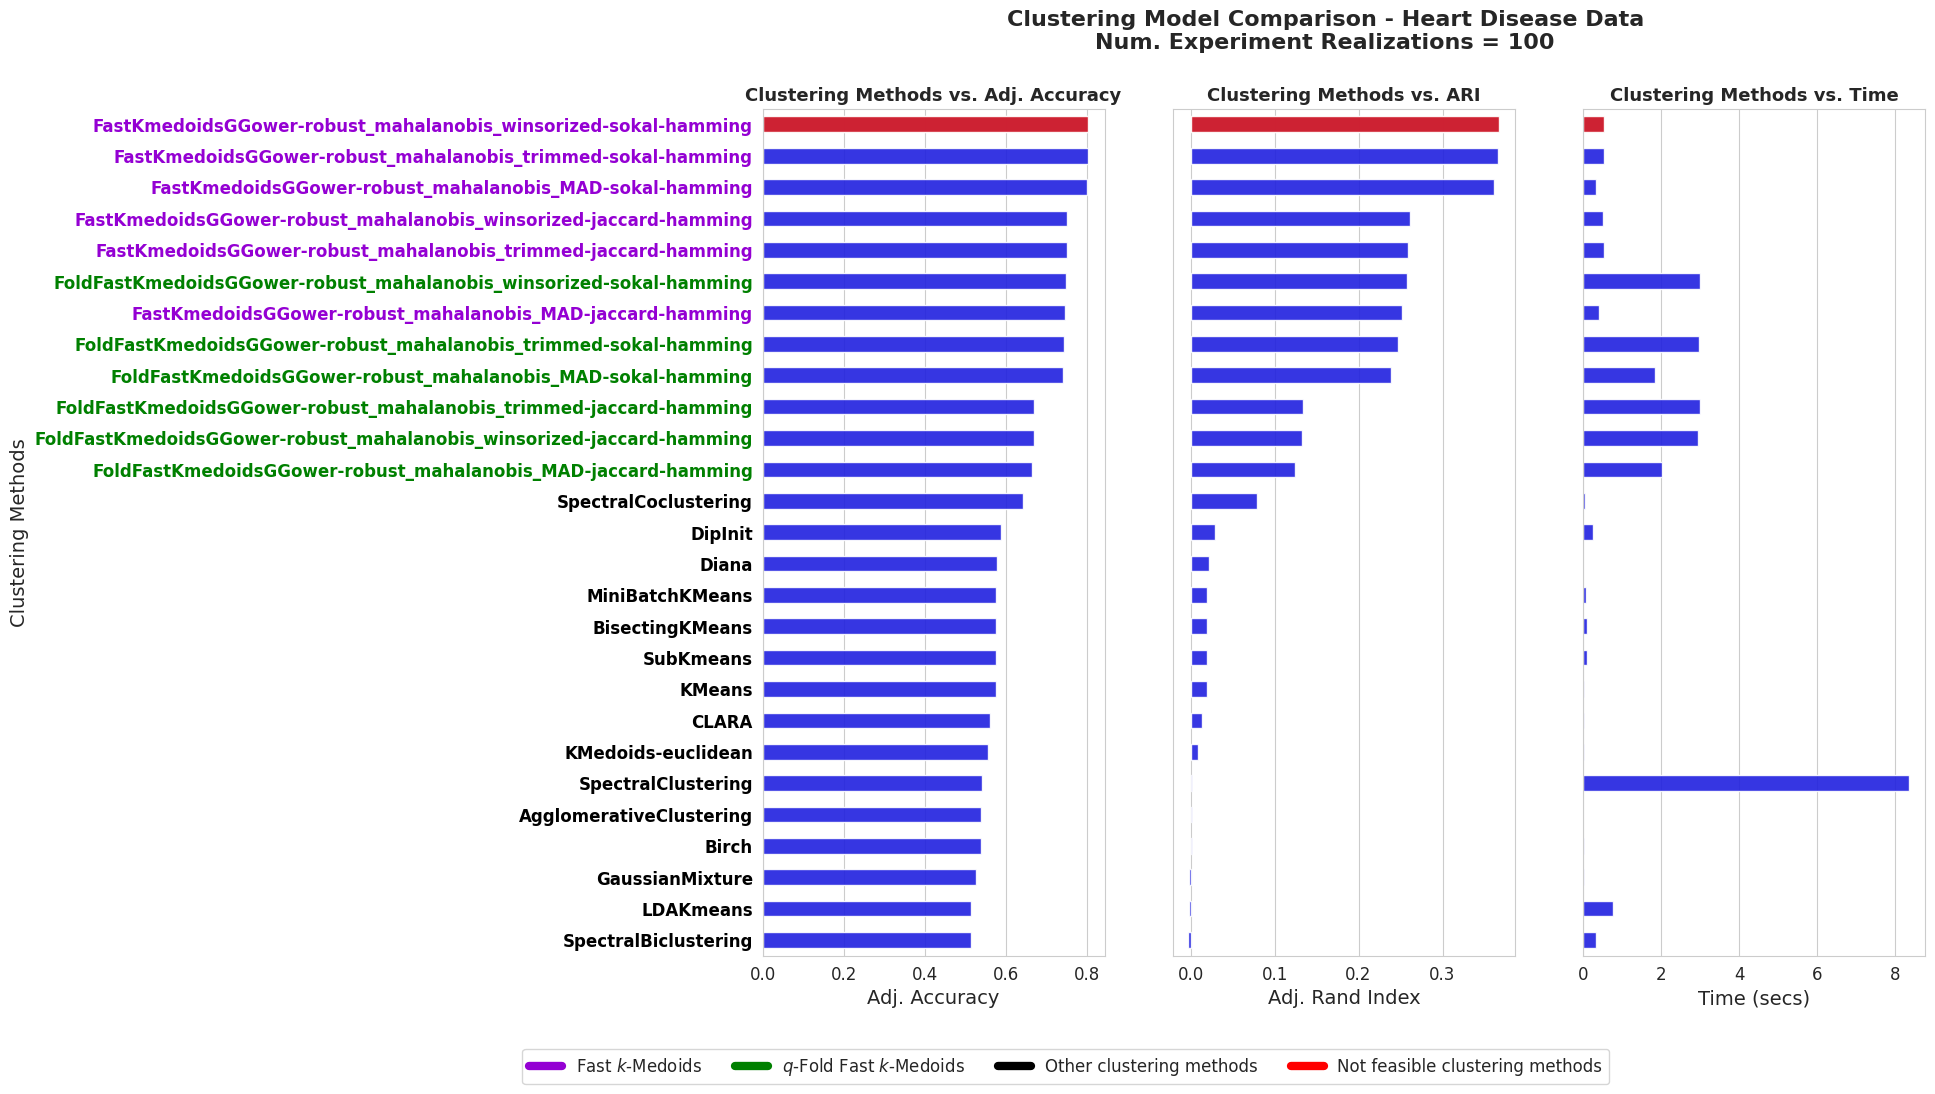

In [58]:
fig, axes = plt.subplots(1,3, figsize=(15,11))
axes = axes.flatten()

ax = sns.barplot(x=avg_adj_accuracy[idx_sorted], y=model_names[idx_sorted], color='blue', width=0.5, alpha=0.9, ax=axes[0])
ax = sns.barplot(x=[avg_adj_accuracy[idx_sorted[0]]], y=[model_names[idx_sorted[0]]], color='red', width=0.5, alpha=0.9, ax=axes[0])

ax = sns.barplot(x=avg_ari[idx_sorted], y=model_names[idx_sorted], color='blue', width=0.5, alpha=0.9, ax=axes[1])
ax = sns.barplot(x=[avg_ari[idx_sorted[0]]], y=[model_names[idx_sorted[0]]], color='red', width=0.5, alpha=0.9, ax=axes[1])

ax = sns.barplot(x=avg_time[idx_sorted], y=model_names[idx_sorted], color='blue', width=0.5, alpha=0.9, ax=axes[2])
ax = sns.barplot(x=[avg_time[idx_sorted[0]]], y=[model_names[idx_sorted[0]]], color='red', width=0.5, alpha=0.9, ax=axes[2])

axes[0].set_ylabel('Clustering Methods', size=14)
axes[0].set_xlabel('Adj. Accuracy', size=14)
#axes[0].set_xticks(np.round(np.linspace(0, np.max(accuracy_list), 7),2)) 
axes[0].tick_params(axis='y', labelsize=12)    
axes[0].tick_params(axis='x', labelsize=12)  
axes[0].set_title('Clustering Methods vs. Adj. Accuracy', size=13, weight='bold')

axes[1].set_xlabel('Adj. Rand Index', size=14)
#axes[1].set_xticks(np.round(np.linspace(0, np.max(adj_rand_index_list), 7),2)) 
axes[1].tick_params(axis='x', labelsize=12)  
axes[1].set_title('Clustering Methods vs. ARI', size=13, weight='bold')
axes[1].set_yticklabels([])

axes[2].set_xlabel('Time (secs)', size=14)
#axes[2].set_xticks(np.round(np.linspace(0, np.max(time_list), 7),2)) 
axes[2].tick_params(axis='x', labelsize=12)  
axes[2].set_title('Clustering Methods vs. Time', size=13, weight='bold')
axes[2].set_yticklabels([])

for label in axes[0].get_yticklabels():
    if label.get_text() in our_methods_1:
        label.set_weight('bold')
        label.set_color('darkviolet') 
    elif label.get_text() in our_methods_2:
        label.set_weight('bold')
        label.set_color('green') 
    elif label.get_text() in other_methods:
        label.set_weight('bold')
        label.set_color('black') 
    elif label.get_text() in not_feasible_methods:
        label.set_weight('bold')
        label.set_color('red') 

# Create legend elements
legend_elements = [
    plt.Line2D([0], [0], color='darkviolet', lw=6, label='Fast $k$-Medoids'),
    plt.Line2D([0], [0], color='green', lw=6, label='$q$-Fold Fast $k$-Medoids'),
    plt.Line2D([0], [0], color='black', lw=6, label='Other clustering methods'),
    plt.Line2D([0], [0], color='red', lw=6, label='Not feasible clustering methods')
]

# Add legend to the figure
axes[0].legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(2.5, -0.1), ncol=len(legend_elements), fontsize=12)

fig.suptitle("Clustering Model Comparison - Heart Disease Data\nNum. Experiment Realizations = 100", fontsize=16, fontweight='bold', y=0.97)

plot_filename = f'plot_results_exp_4_heart_disease_{file_id}_acc.png'
plot_save_path = os.path.join(results_folder_path, plot_filename)
fig.savefig(plot_save_path, format='png', dpi=300, bbox_inches="tight", pad_inches=0.2)

plt.show()

In [59]:
# Results as table 
avg_results_df = pd.DataFrame(avg_results)
avg_results_df.index.name = 'models'
avg_results_df = avg_results_df.drop(['labels', 'adj_labels'], axis=1)
avg_results_df_sorted_acc = avg_results_df.sort_values(by='adj_accuracy', ascending=False)
avg_results_df_sorted_ari = avg_results_df.sort_values(by='ARI', ascending=False)

In [60]:
avg_results_df_sorted_acc

,time,adj_accuracy,ARI
models,,,
FastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming,0.520695,0.803502,0.367619
FastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming,0.543122,0.802997,0.366607
FastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming,0.335902,0.800976,0.361187
FastKmedoidsGGower-robust_mahalanobis_winsorized-jaccard-hamming,0.514427,0.751684,0.261853
FastKmedoidsGGower-robust_mahalanobis_trimmed-jaccard-hamming,0.542236,0.750000,0.258329
FoldFastKmedoidsGGower-robust_mahalanobis_winsorized-sokal-hamming,2.983534,0.749731,0.257631
FastKmedoidsGGower-robust_mahalanobis_MAD-jaccard-hamming,0.394711,0.746700,0.252012
FoldFastKmedoidsGGower-robust_mahalanobis_trimmed-sokal-hamming,2.971029,0.744209,0.246474
FoldFastKmedoidsGGower-robust_mahalanobis_MAD-sokal-hamming,1.839263,0.741414,0.238120


In [63]:
random_state_mds = 6863

mds = MDS(n_components=2, dissimilarity='precomputed', random_state=random_state_mds) 

fastGG = FastGGowerDistMatrix(frac_sample_size=1, random_state=random_state_mds, p1=p1, p2=p2, p3=p3, 
                 d1='robust_mahalanobis', d2='sokal', d3='hamming', 
                 robust_method='winsorized', alpha=0.05)

fastGG.compute(X)

X_mds = mds.fit_transform(fastGG.D_GGower)

/home/fabio/fabio_scielzo_ortiz/paper-2-code/.venv/lib/python3.12/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


In [64]:
#outliers_bool = np.array([0 if x not in outliers_idx else 1 for x in range(0, len(X))])

sorted_methods_accuracy = list(avg_results_df_sorted_acc.index)

our_methods_1_sorted_acc = [x for x in list(sorted_methods_accuracy) if x in our_methods_1]
our_methods_2_sorted_acc = [x for x in list(sorted_methods_accuracy) if x in our_methods_2]
other_methods_sorted_acc = [x for x in list(sorted_methods_accuracy) if x in other_methods]
best_our_methods_1 = our_methods_1_sorted_acc[0]
best_our_methods_2 = our_methods_2_sorted_acc[0]
best_other_methods = other_methods_sorted_acc[0]
additional_methods = ['KMeans', 'KMedoids-euclidean']

methods_to_plot = [best_our_methods_1, best_our_methods_2, best_other_methods] + additional_methods
names_to_plot = [('Best Fast k-medoids' if x in our_methods_1 else 'Best q-Fold Fast k-medoids' if x in our_methods_2 else x) for x in methods_to_plot]
names_to_plot = dict(zip(methods_to_plot, names_to_plot))
y_pred_dict = {names_to_plot[method]: results[random_state_mds]['adj_labels'][method][fastGG.sample_index] for method in methods_to_plot}
accuracy_dict = {names_to_plot[method]: results[random_state_mds]['adj_accuracy'][method] for method in methods_to_plot}
time_dict = {names_to_plot[method]: results[random_state_mds]['time'][method] for method in methods_to_plot}

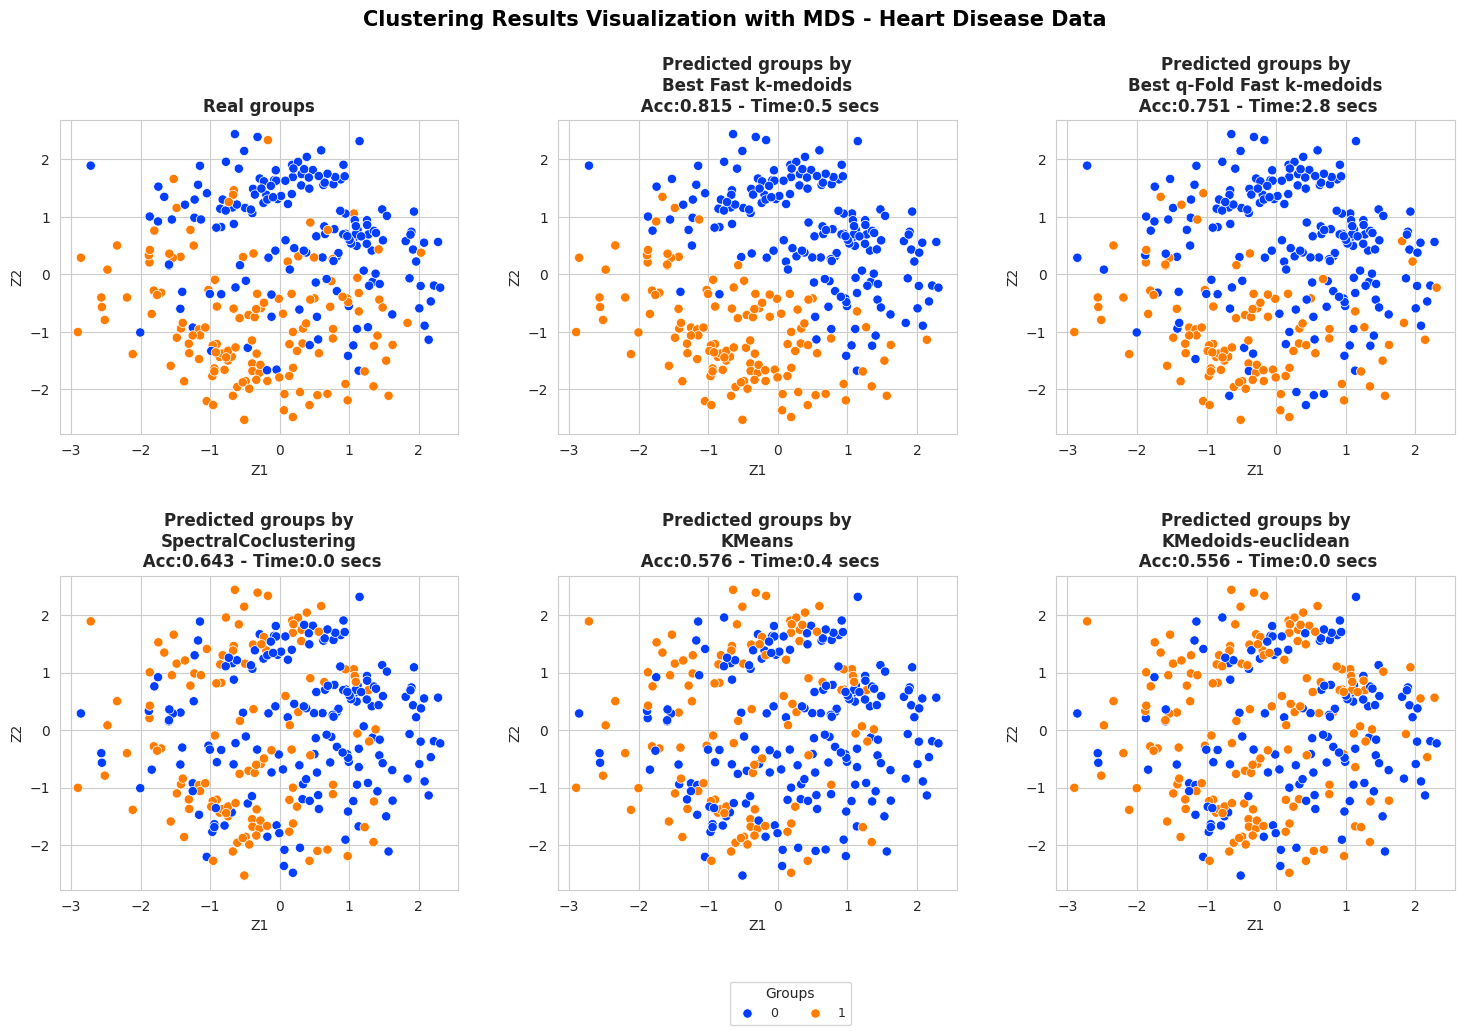

In [66]:
plot_filename = f'mds_plot_exp_4_heart_disease_{file_id}.png'
results_folder_path = os.path.join(current_path, '..', '..', 'results', 'results_experiment_4', 'heart_disease')
plot_save_path = os.path.join(results_folder_path, plot_filename)

clustering_MDS_plot_multiple_methods(X_mds=X_mds, y_pred=y_pred_dict, 
                                     y_true=y[fastGG.sample_index],
                                     title=f"Clustering Results Visualization with MDS - Heart Disease Data", 
                                     accuracy=accuracy_dict, time=time_dict, n_rows=2,
                                     figsize=(18,10), bbox_to_anchor=(0.75,-1.9), 
                                     title_size=15, title_weight='bold', 
                                     subtitles_size=12,
                                     points_size=45, title_height=0.99, 
                                     wspace=0.25, hspace=0.45, 
                                     outliers_boolean=None, #outliers_bool[fastGG.sample_index],
                                     n_cols_legend=2, legend_title='Groups', legend_size=9, 
                                     save = True, file_name = plot_save_path
)